# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import calendar
from math import sqrt
from pandas import datetime
import plotly.express as px
from scipy.stats import boxcox
import plotly.graph_objects as go
from pandas.plotting import lag_plot
import statsmodels.formula.api as smf 
from plotly.subplots import make_subplots
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

/var/folders/dt/ty2ltnkd5bl9j772y8m9kqp00000gn/T/ipykernel_18566/2173892203.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


# Import Dataset

In [2]:
df = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')
df.head(10)

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996
5,Q2_87,2104.411995
6,Q3_87,2014.362999
7,Q4_87,1991.746998
8,Q1_88,1869.049999
9,Q2_88,2313.631996


# Data Exploration

In [3]:
# Checking missing value
df.isnull().sum()

Quarter    0
Sales      0
dtype: int64

# Descriptive Analysis

In [4]:
print('Shape of the data',df.shape)

Shape of the data (42, 2)


In [5]:
df.dtypes

Quarter     object
Sales      float64
dtype: object

In [6]:
df.nunique()

Quarter    42
Sales      42
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Quarter  42 non-null     object 
 1   Sales    42 non-null     float64
dtypes: float64(1), object(1)
memory usage: 800.0+ bytes


In [8]:
df.describe()

,Sales
count,42.000000
mean,2994.353308
std,977.930896
min,1547.818996
25%,2159.714247
50%,2782.376999
75%,3609.250000
max,5253.000000


# Feature Engineering


In [9]:
# Converting the Quarters into Years
df['Quarter_Year'] = df['Quarter'].str.split('_').apply(lambda x: ' 19'.join(x[:]))
#Clean way to convert quarterly periods to datetime in pandas
df.head(10)

,Quarter,Sales,Quarter_Year
0,Q1_86,1734.827000,Q1 1986
1,Q2_86,2244.960999,Q2 1986
2,Q3_86,2533.804993,Q3 1986
3,Q4_86,2154.962997,Q4 1986
4,Q1_87,1547.818996,Q1 1987
5,Q2_87,2104.411995,Q2 1987
6,Q3_87,2014.362999,Q3 1987
7,Q4_87,1991.746998,Q4 1987
8,Q1_88,1869.049999,Q1 1988
9,Q2_88,2313.631996,Q2 1988


# Coverting Quarter Years with Quarter Start Date Year (Date Month and Year)

In [10]:
# Converting into datetime formate as the index was not in correct formate.
df['Date'] = (pd.to_datetime(df['Quarter_Year'].str.split(' ').apply(lambda x: ''.join(x[::-1])),dayfirst=True))
df.head(10)

,Quarter,Sales,Quarter_Year,Date
0,Q1_86,1734.827000,Q1 1986,1986-01-01
1,Q2_86,2244.960999,Q2 1986,1986-04-01
2,Q3_86,2533.804993,Q3 1986,1986-07-01
3,Q4_86,2154.962997,Q4 1986,1986-10-01
4,Q1_87,1547.818996,Q1 1987,1987-01-01
5,Q2_87,2104.411995,Q2 1987,1987-04-01
6,Q3_87,2014.362999,Q3 1987,1987-07-01
7,Q4_87,1991.746998,Q4 1987,1987-10-01
8,Q1_88,1869.049999,Q1 1988,1988-01-01
9,Q2_88,2313.631996,Q2 1988,1988-04-01


# Extracting the Quarters and putting in column

In [11]:
df['Quarters'] = 0

for i in range(42):
    n = df['Quarter'][i]
    df['Quarters'][i] = n[0:2]
    
df.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2


# Creating Dummy Variables for Quarters Variable

In [12]:
dummy = pd.DataFrame(pd.get_dummies(df['Quarters']))
df1 = pd.concat((df, dummy), axis=1)

df1.head()

,Quarter,Sales,Quarter_Year,Date,Quarters,Q1,Q2,Q3,Q4
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,1,0,0,0
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,0,1,0,0
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,0,0,1,0
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,0,0,0,1
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,1,0,0,0


# Dropping all the unnecessary column

In [13]:
df1.drop(['Quarter','Quarter_Year'] , axis =1, inplace = True)
df1.head()

,Sales,Date,Quarters,Q1,Q2,Q3,Q4
0,1734.827000,1986-01-01,Q1,1,0,0,0
1,2244.960999,1986-04-01,Q2,0,1,0,0
2,2533.804993,1986-07-01,Q3,0,0,1,0
3,2154.962997,1986-10-01,Q4,0,0,0,1
4,1547.818996,1987-01-01,Q1,1,0,0,0


# Making the Date as DateTime index for the Dataframe

In [14]:
df1.set_index('Date',inplace=True)
df1.index.year

Int64Index([1986, 1986, 1986, 1986, 1987, 1987, 1987, 1987, 1988, 1988, 1988,
            1988, 1989, 1989, 1989, 1989, 1990, 1990, 1990, 1990, 1991, 1991,
            1991, 1991, 1992, 1992, 1992, 1992, 1993, 1993, 1993, 1993, 1994,
            1994, 1994, 1994, 1995, 1995, 1995, 1995, 1996, 1996],
           dtype='int64', name='Date')

In [15]:
df1.head()

,Sales,Quarters,Q1,Q2,Q3,Q4
Date,,,,,,
1986-01-01,1734.827000,Q1,1,0,0,0
1986-04-01,2244.960999,Q2,0,1,0,0
1986-07-01,2533.804993,Q3,0,0,1,0
1986-10-01,2154.962997,Q4,0,0,0,1
1987-01-01,1547.818996,Q1,1,0,0,0


### Separating Month and Year into Separate Column for Visualization and removing meaningful insight of the data

In [16]:
df["Date"] = pd.to_datetime(df.Date,format="%b-%y")
df["month"] = df.Date.dt.strftime("%b") # month extraction
df["year"] = df.Date.dt.strftime("%Y") # year extraction
df.head(10)

,Quarter,Sales,Quarter_Year,Date,Quarters,month,year
0,Q1_86,1734.827000,Q1 1986,1986-01-01,Q1,Jan,1986
1,Q2_86,2244.960999,Q2 1986,1986-04-01,Q2,Apr,1986
2,Q3_86,2533.804993,Q3 1986,1986-07-01,Q3,Jul,1986
3,Q4_86,2154.962997,Q4 1986,1986-10-01,Q4,Oct,1986
4,Q1_87,1547.818996,Q1 1987,1987-01-01,Q1,Jan,1987
5,Q2_87,2104.411995,Q2 1987,1987-04-01,Q2,Apr,1987
6,Q3_87,2014.362999,Q3 1987,1987-07-01,Q3,Jul,1987
7,Q4_87,1991.746998,Q4 1987,1987-10-01,Q4,Oct,1987
8,Q1_88,1869.049999,Q1 1988,1988-01-01,Q1,Jan,1988
9,Q2_88,2313.631996,Q2 1988,1988-04-01,Q2,Apr,1988


# Data Visualization

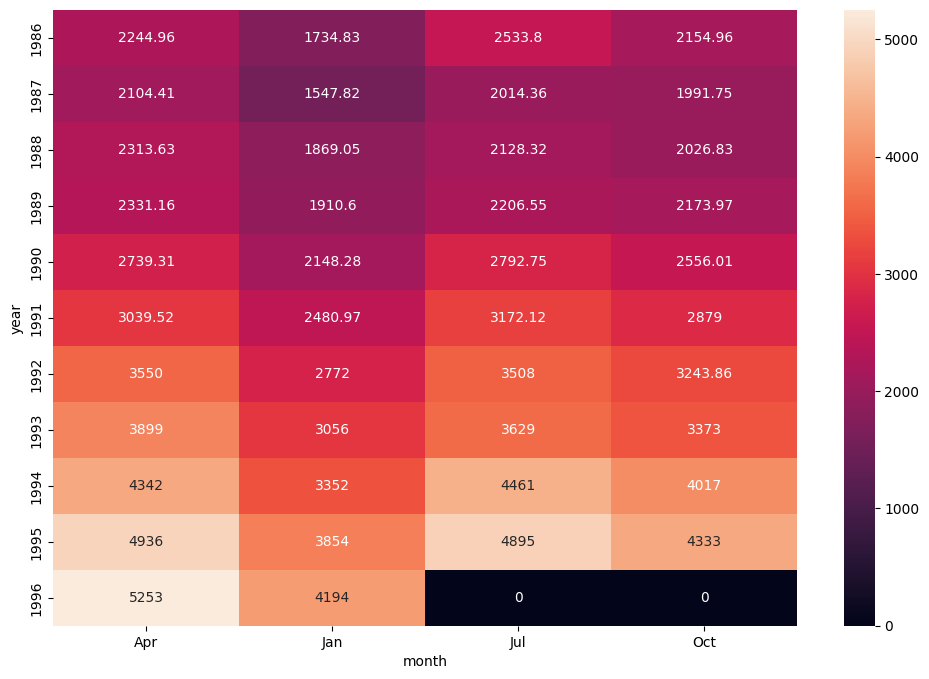

In [17]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=df, values="Sales", index="year", columns="month", aggfunc="mean", fill_value=0)
sns.heatmap(heatmap_y_month, annot=True, fmt="g")
plt.show()

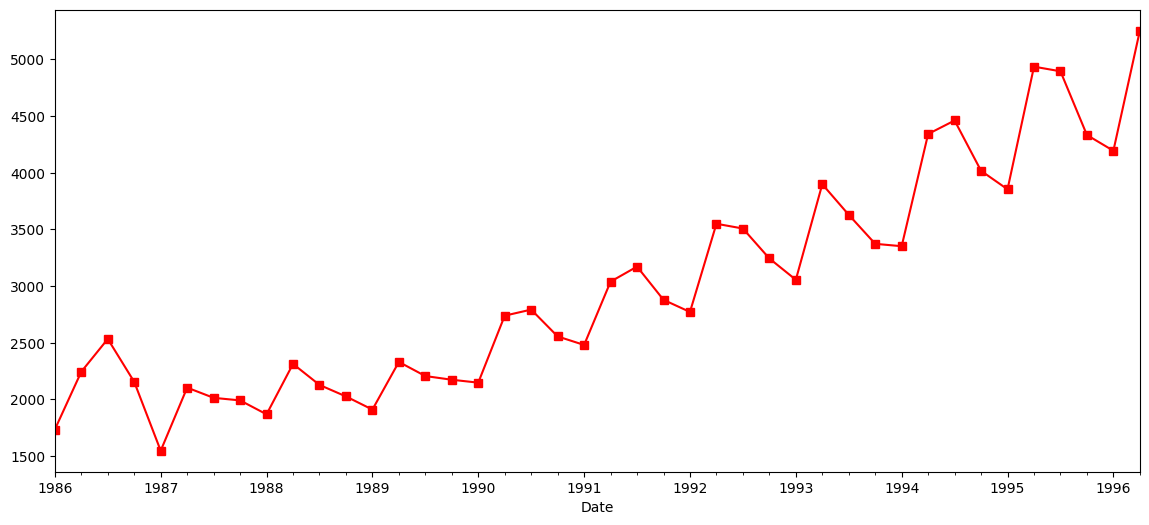

In [18]:
# Line plot
df1['Sales'].plot(figsize=(14,6), color='red', marker='s')
plt.show()

### We can see that there is an increasing Trend. So, Trend is not constant. Variance is also not constant.Hence the time serise is not stationary.

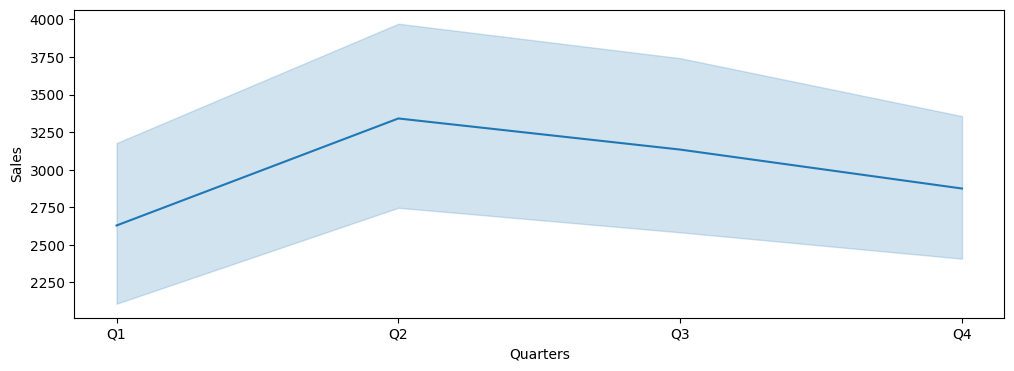

In [19]:
# Line Plot Using Quarters as Y axis and Sales as X axis
plt.figure(figsize=(12,4))
sns.lineplot(x="Quarters", y="Sales", data=df)
plt.show()

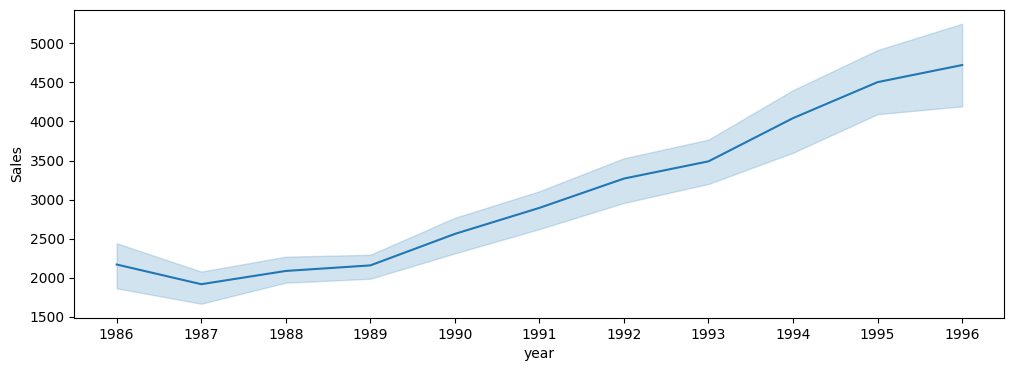

In [20]:
plt.figure(figsize=(12,4))
sns.lineplot(x="year",y="Sales",data=df)
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

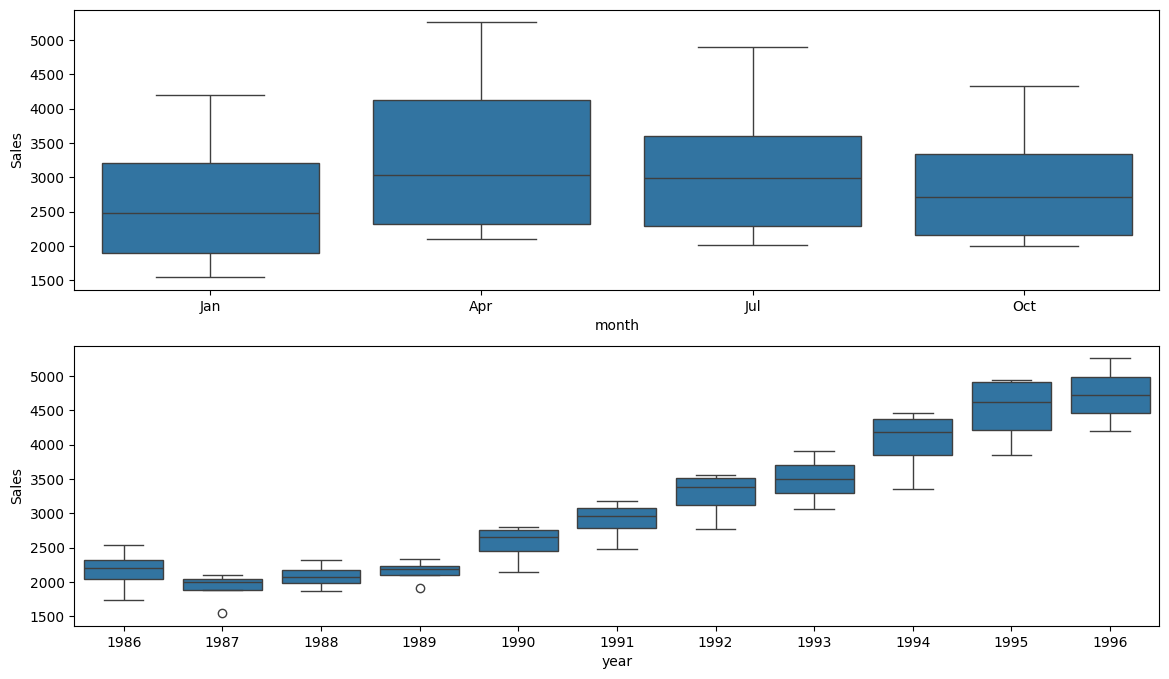

In [21]:
# Box Plot of Each Year by Quaterly Intervals
plt.figure(figsize=(14,8))
plt.subplot(211)
sns.boxplot(x="month",y="Sales",data=df)
plt.subplot(212)
sns.boxplot(x="year",y="Sales",data=df)
plt.show()

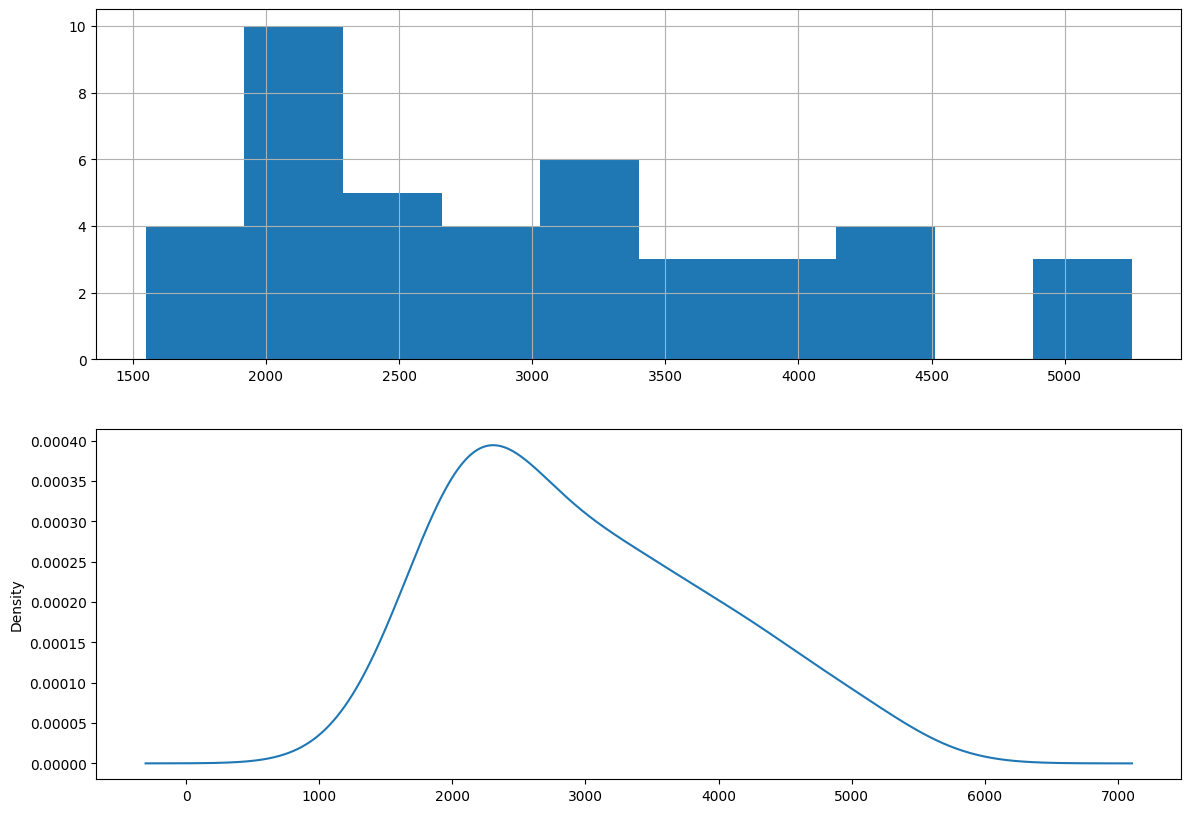

In [22]:
# Histogram and Density Plots
plt.figure(figsize=(14,10))
plt.subplot(211)
df.Sales.hist()
plt.subplot(212)
df.Sales.plot(kind='kde')
plt.show()

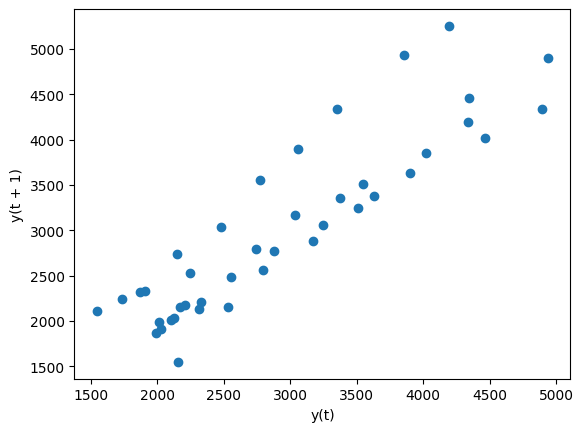

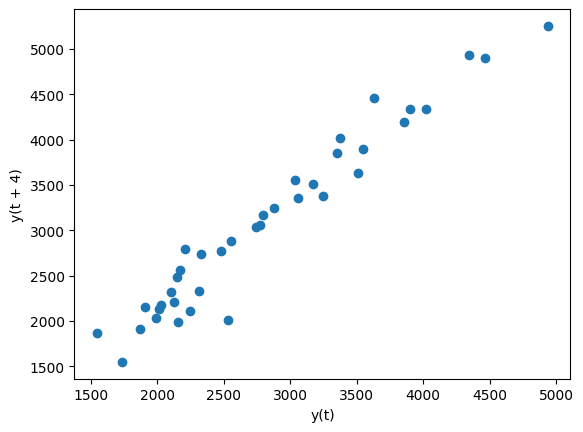

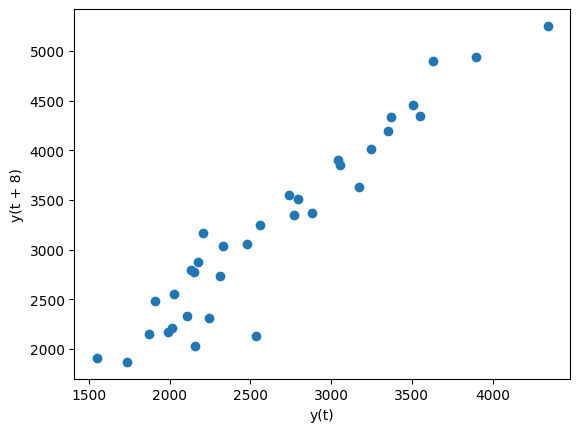

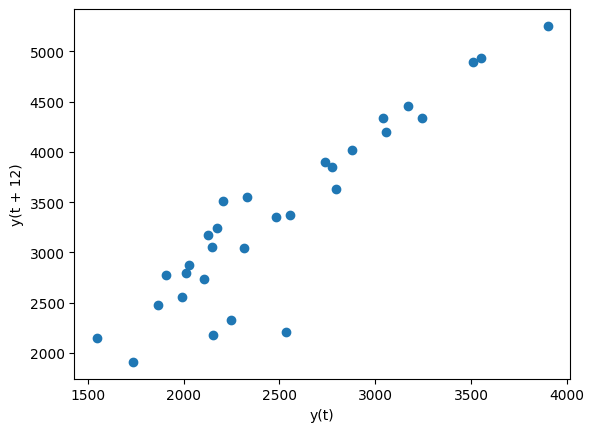

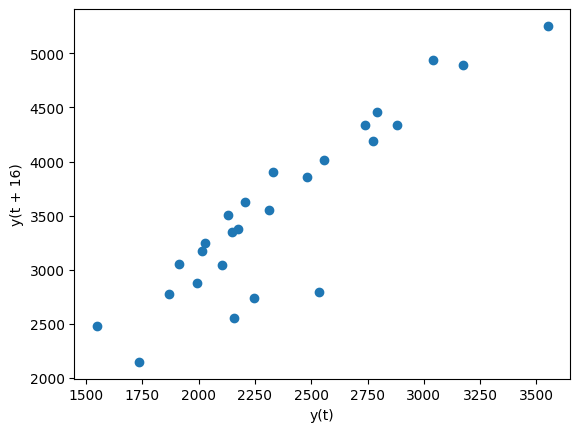

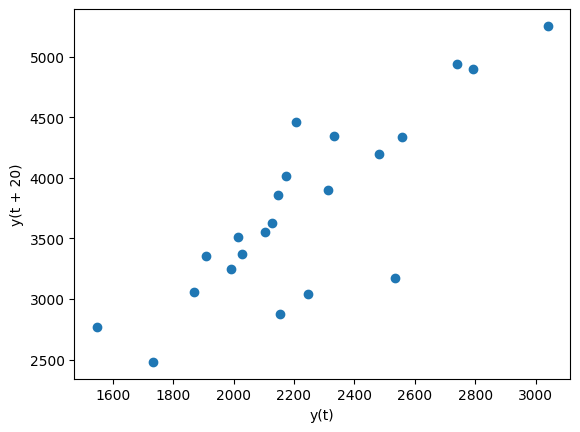

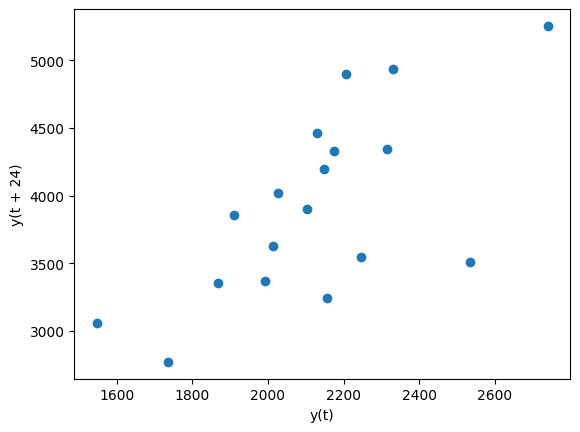

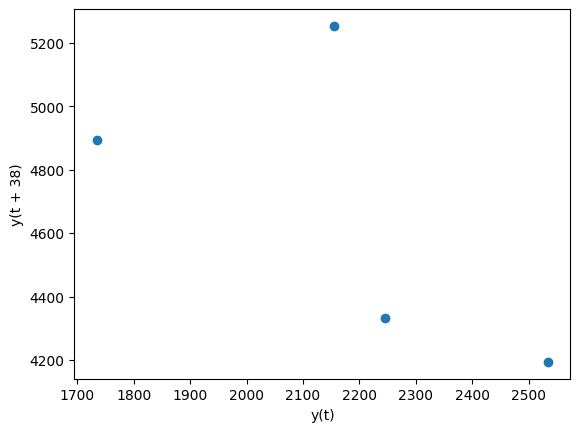

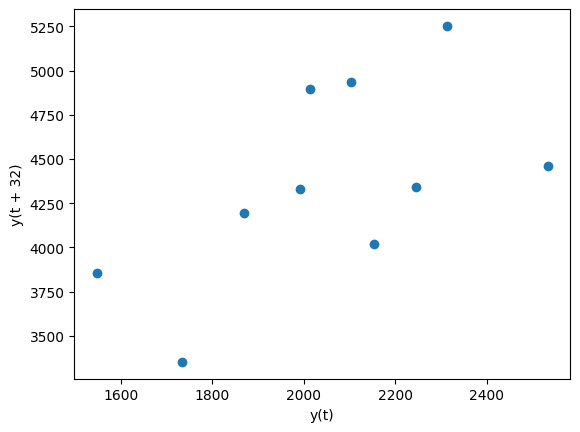

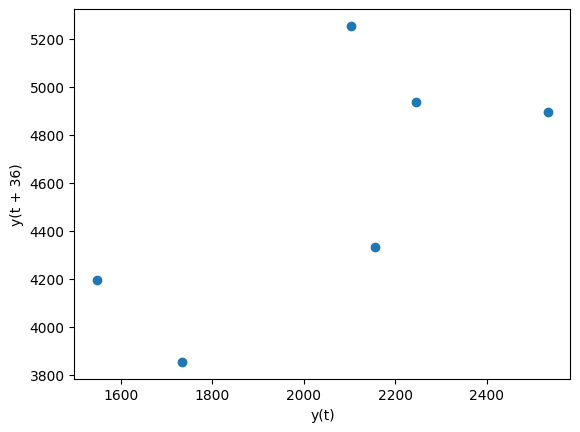

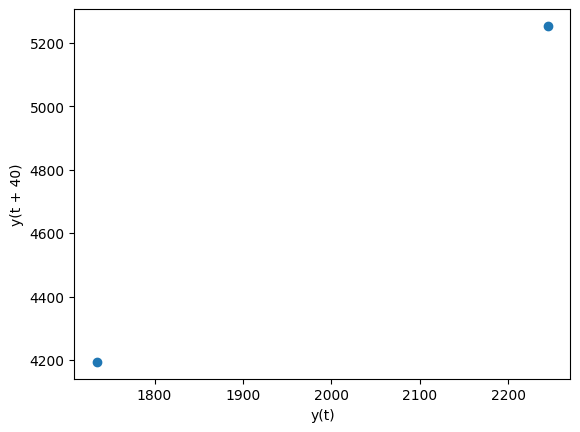

In [23]:
# create a scatter plot
for i in [1, 4, 8, 12, 16, 20, 24, 38, 32, 36, 40]:
    lag_plot(df.Sales, lag=i)
    plt.show()

# Moving Average

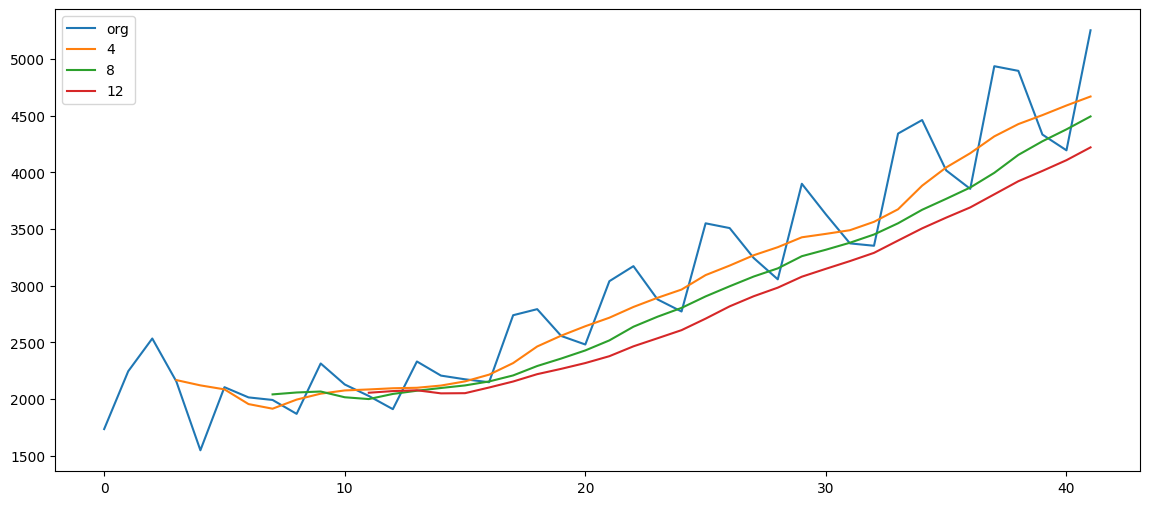

In [24]:
plt.figure(figsize=(14,6))
df.Sales.plot(label="org")
for i in range(4,13,4):
    df["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

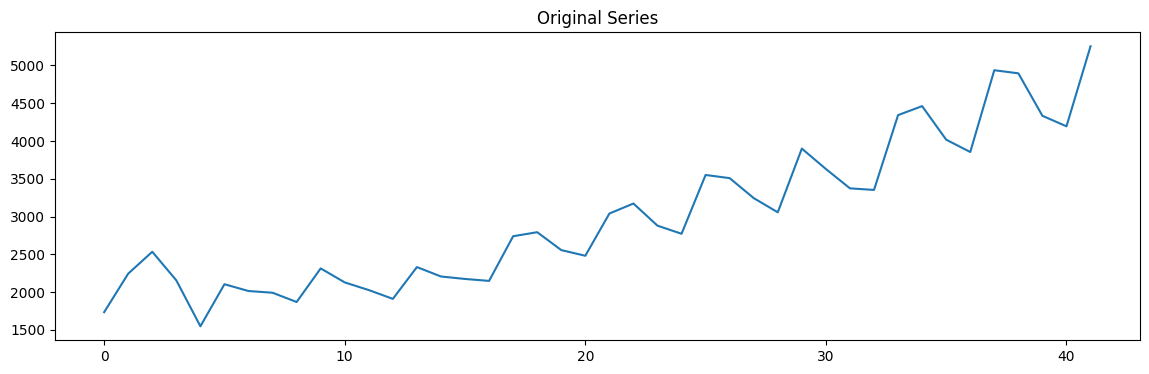

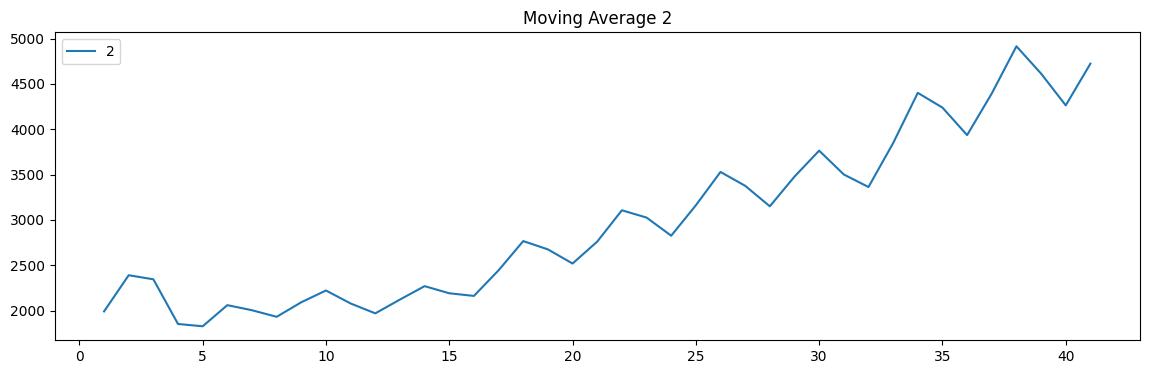

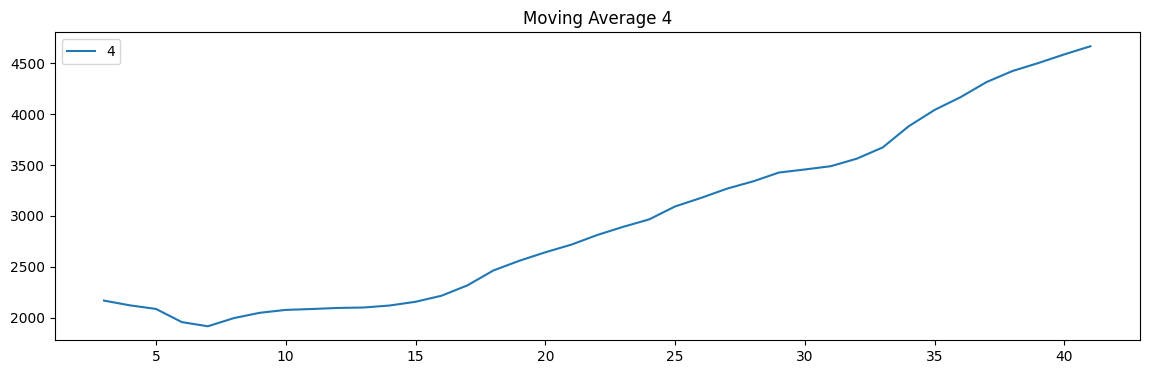

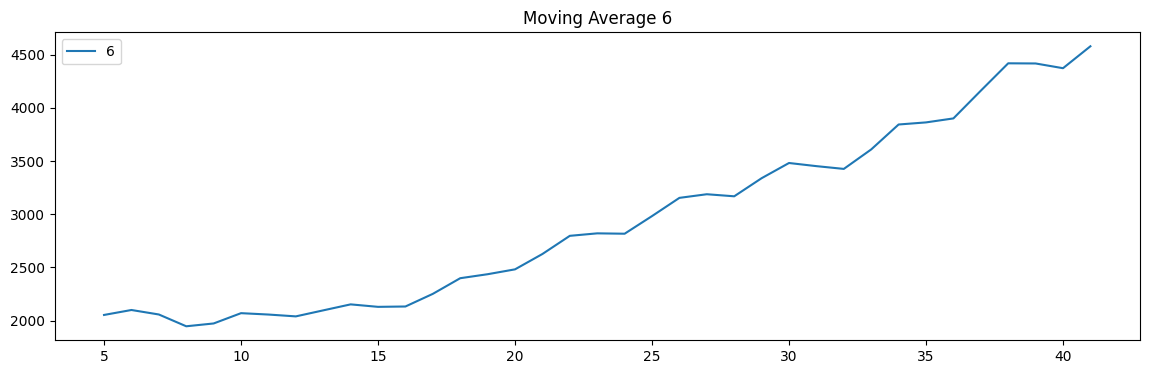

In [25]:
plt.figure(figsize=(14,4))
df.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,7,2):
    plt.figure(figsize=(14,4))
    df["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

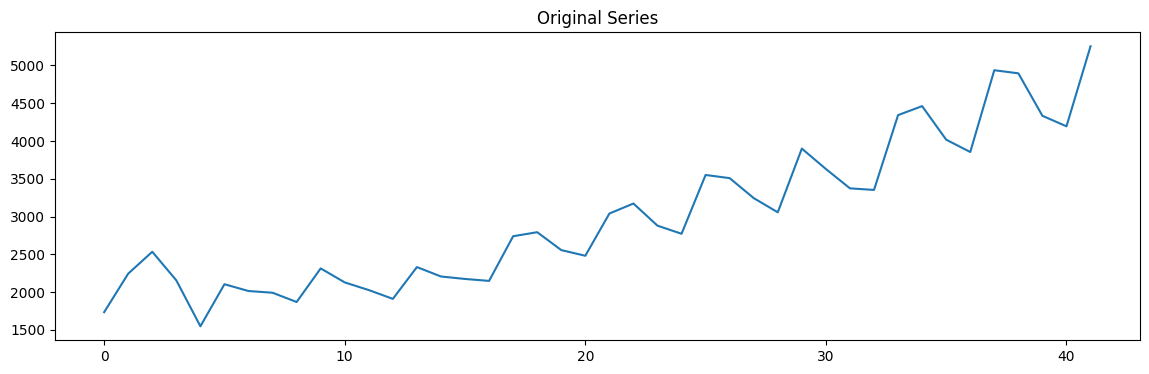

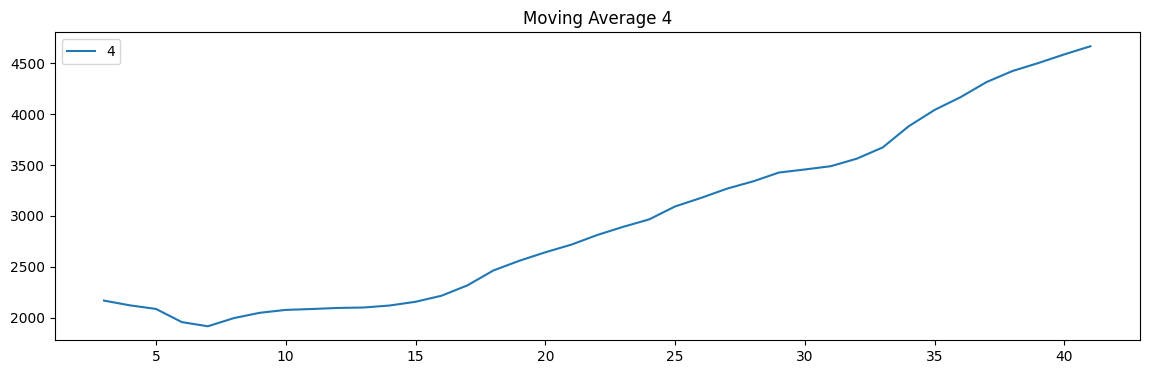

In [26]:
plt.figure(figsize=(14,4))
df.Sales.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(14,4))
df["Sales"].rolling(4).mean().plot(label=str(4))
plt.title("Moving Average "+str(4))
plt.legend(loc='best')
plt.show()

# Time series decomposition plot

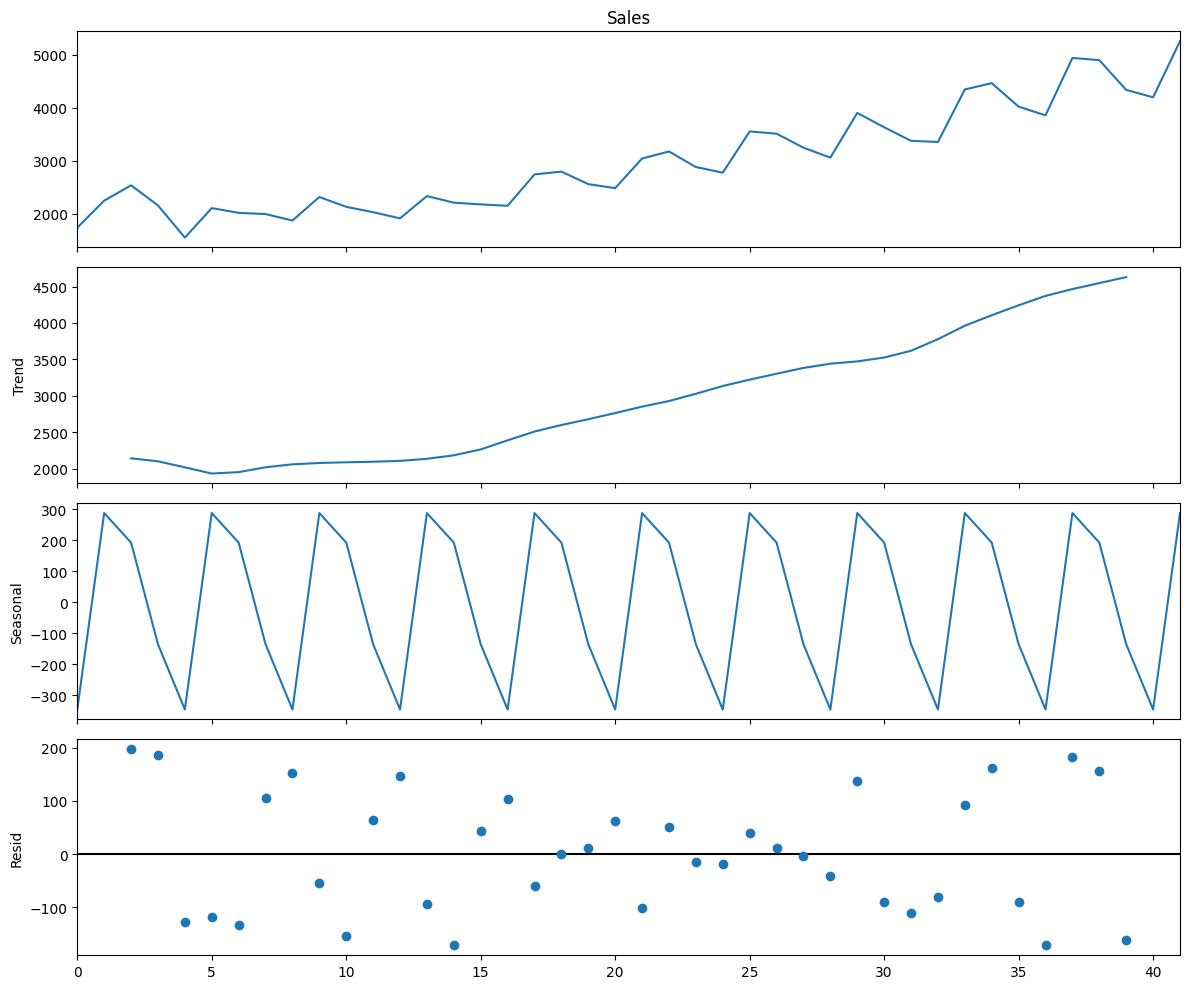

In [27]:
decompose_ts_add = seasonal_decompose(df.Sales,period=4)
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

# ACF plots and PACF plots


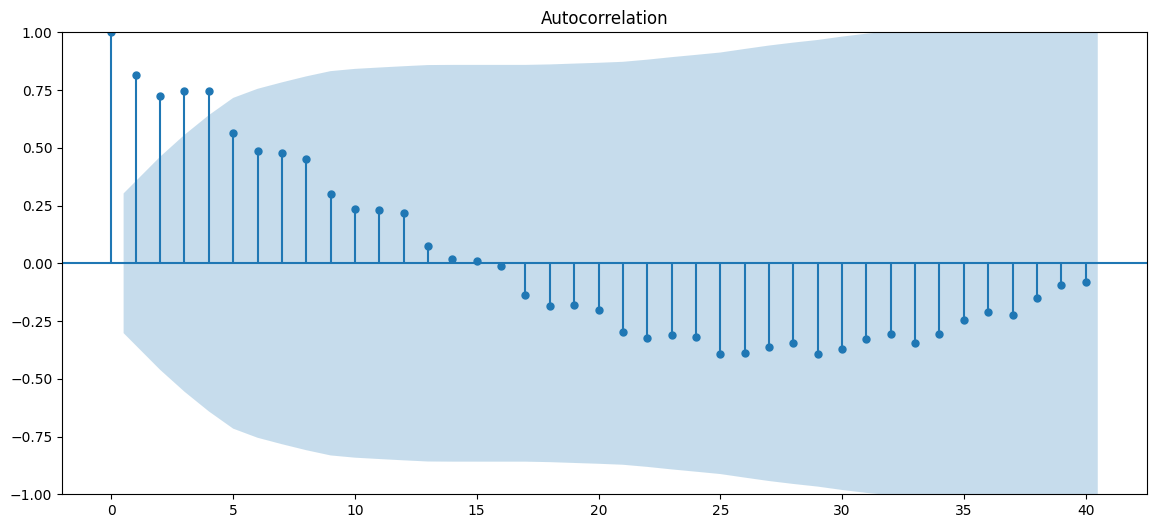

In [28]:
# Autocorrelation Function (ACF)
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    tsa_plots.plot_acf(df.Sales,lags=40)
    plt.show()

### Autocorrelation is the correlation between a time series (signal) and a delayed version of itself, while the ACF plots the correlation coefficient against the lag, and it’s a visual representation of autocorrelation

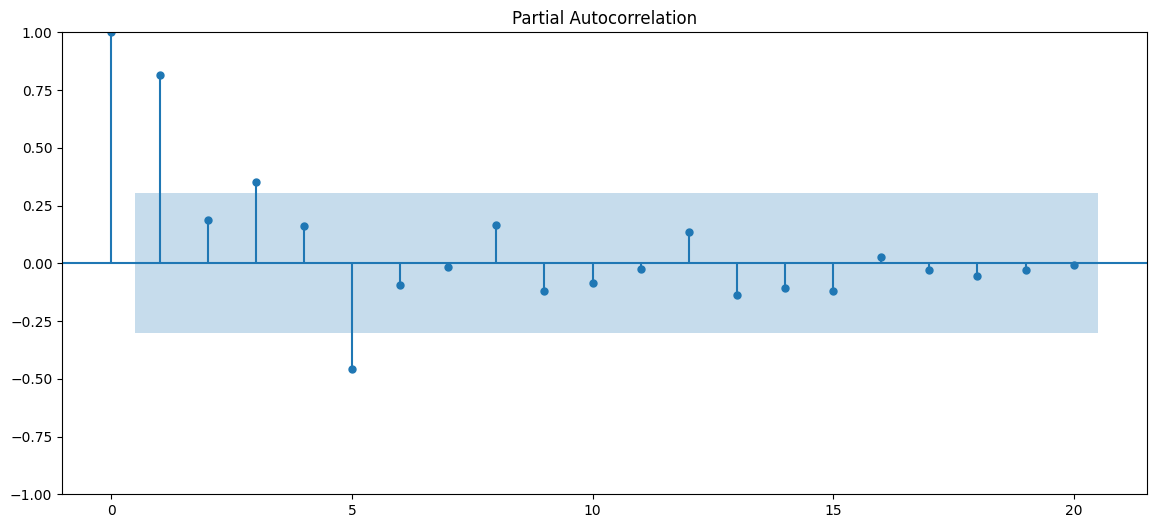

In [29]:
# Partial Autocorrelation Function (PACF)
import statsmodels.graphics.tsaplots as tsa_plots
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    tsa_plots.plot_pacf(df.Sales,lags=20)
    plt.show()

### A partial autocorrelation function captures a “direct” correlation between time series and a lagged version of itself.

# Sampling


In [111]:
# Linear interpolation
# UpSampling with respect to month
upsampled_month = df1.drop(['Quarters','Q1','Q2','Q3','Q4'], axis=1)
upsampled_month = upsampled_month.resample('M').mean()
print(upsampled_month.head(13))

                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28          NaN
1986-03-31          NaN
1986-04-30  2244.960999
1986-05-31          NaN
1986-06-30          NaN
1986-07-31  2533.804993
1986-08-31          NaN
1986-09-30          NaN
1986-10-31  2154.962997
1986-11-30          NaN
1986-12-31          NaN
1987-01-31  1547.818996


                  Sales
Date                   
1986-01-31  1734.827000
1986-02-28  1904.871666
1986-03-31  2074.916332
1986-04-30  2244.960999
1986-05-31  2341.242330
1986-06-30  2437.523661
1986-07-31  2533.804993
1986-08-31  2407.524328
1986-09-30  2281.243663
1986-10-31  2154.962997
1986-11-30  1952.581664
1986-12-31  1750.200330
1987-01-31  1547.818996


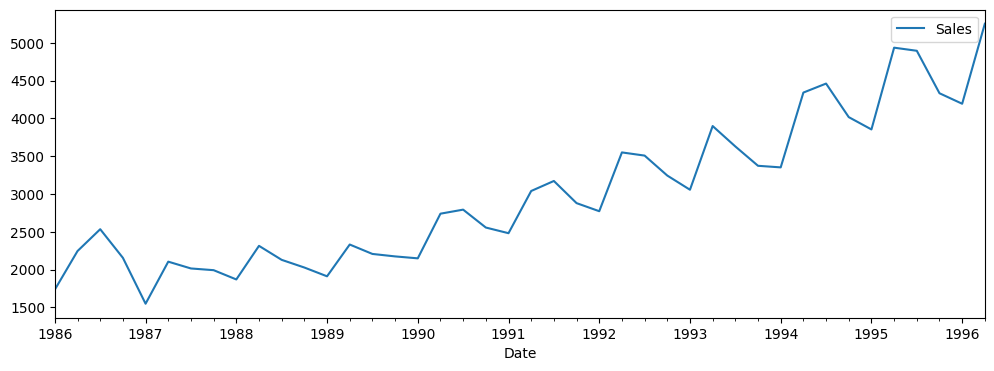

In [31]:
interpolated_month = upsampled_month.interpolate(method='linear')
print(interpolated_month.head(13))
interpolated_month.plot(figsize=(12,4))
plt.show()

In [32]:
interpolated_month

,Sales
Date,
1986-01-31,1734.827000
1986-02-28,1904.871666
1986-03-31,2074.916332
1986-04-30,2244.960999
1986-05-31,2341.242330
...,...
1995-12-31,4240.333333
1996-01-31,4194.000000
1996-02-29,4547.000000


In [33]:
visual = interpolated_month.copy()
visual.reset_index(inplace=True)
visual['date'] = pd.to_datetime(visual['Date'])
visual['year'] = visual['Date'].dt.year
visual['month'] = visual['Date'].dt.month
visual['week'] = visual['Date'].dt.isocalendar().week
visual['quarter'] = visual['Date'].dt.quarter
visual['day_of_week'] = visual['Date'].dt.day_name()
visual.drop('Date', axis =1 , inplace= True)
visual[:2]

,Sales,date,year,month,week,quarter,day_of_week
0,1734.827000,1986-01-31,1986,1,5,1,Friday
1,1904.871666,1986-02-28,1986,2,9,1,Friday


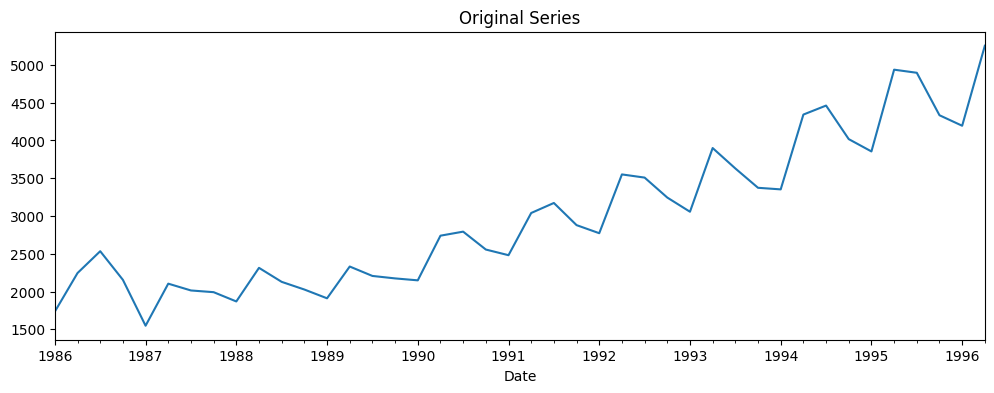

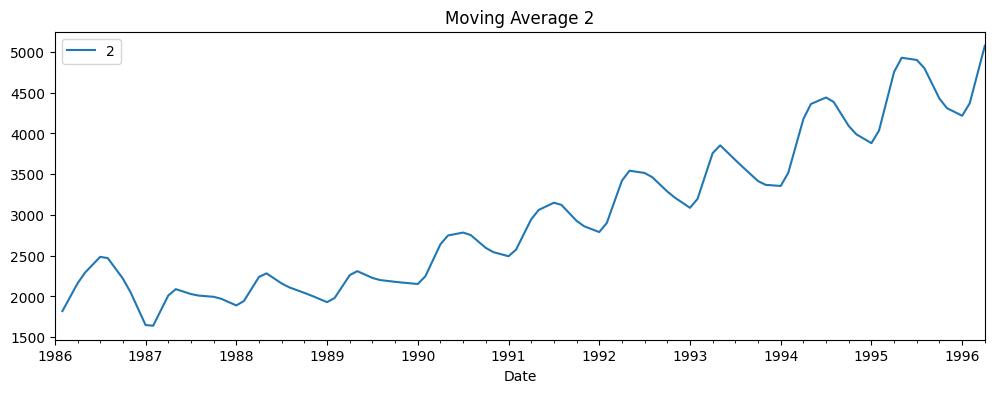

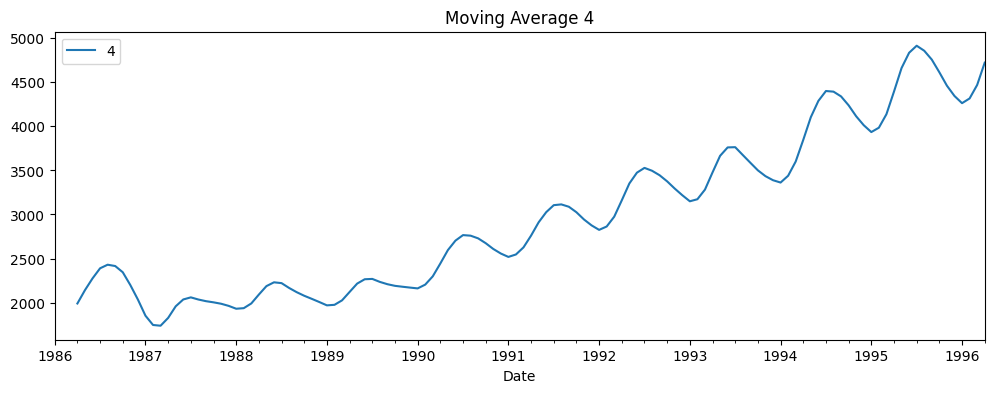

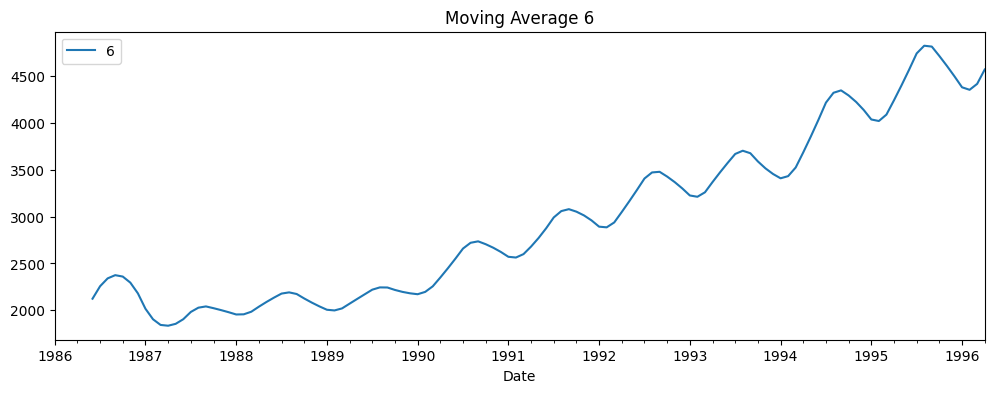

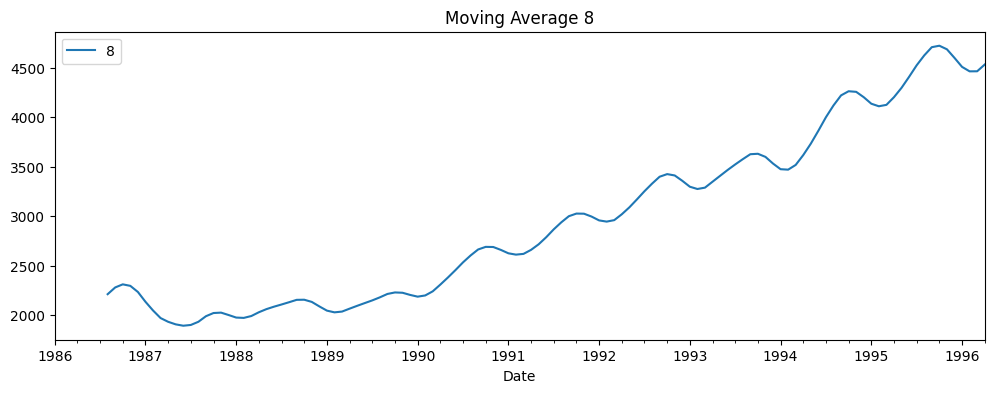

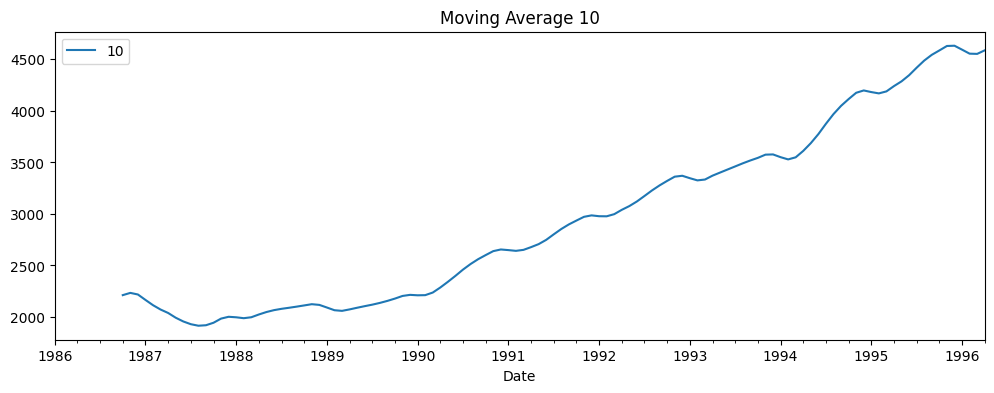

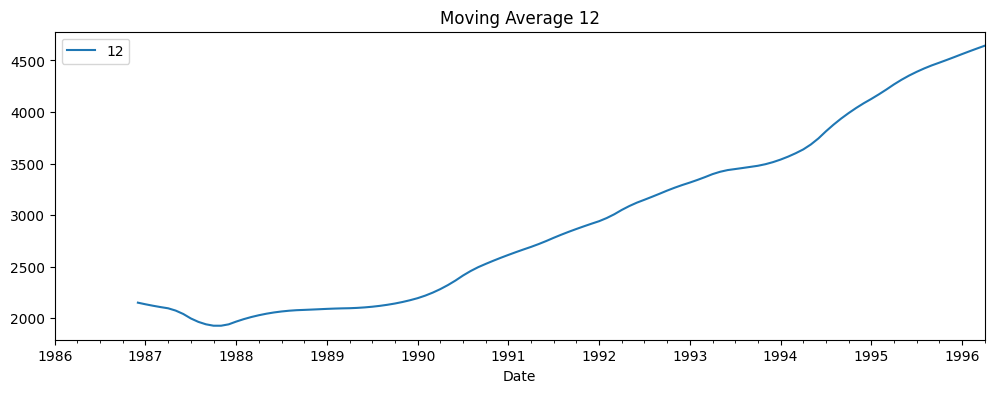

In [34]:
plt.figure(figsize=(12,4))
interpolated_month.Sales.plot(label="org")
plt.title("Original Series")
for i in range(2,13,2):
    plt.figure(figsize=(12,4))
    interpolated_month["Sales"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

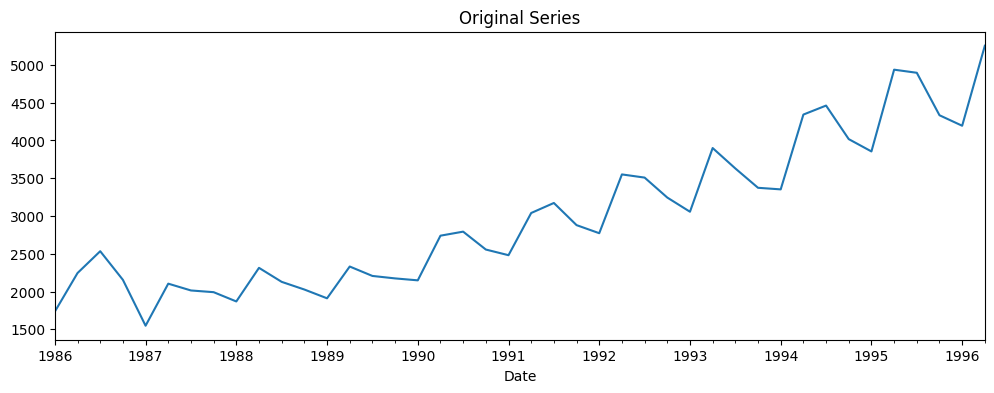

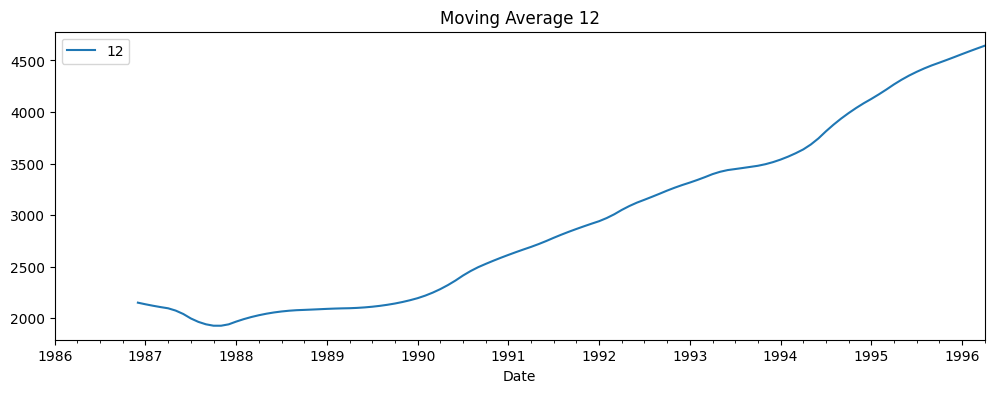

In [35]:
plt.figure(figsize=(12,4))
interpolated_month.Sales.plot(label="org")
plt.title("Original Series")
plt.figure(figsize=(12,4))
interpolated_month["Sales"].rolling(12).mean().plot(label=str(12))
plt.title("Moving Average "+str(12))
plt.legend(loc='best')
plt.show()

# Time Series Decomposition


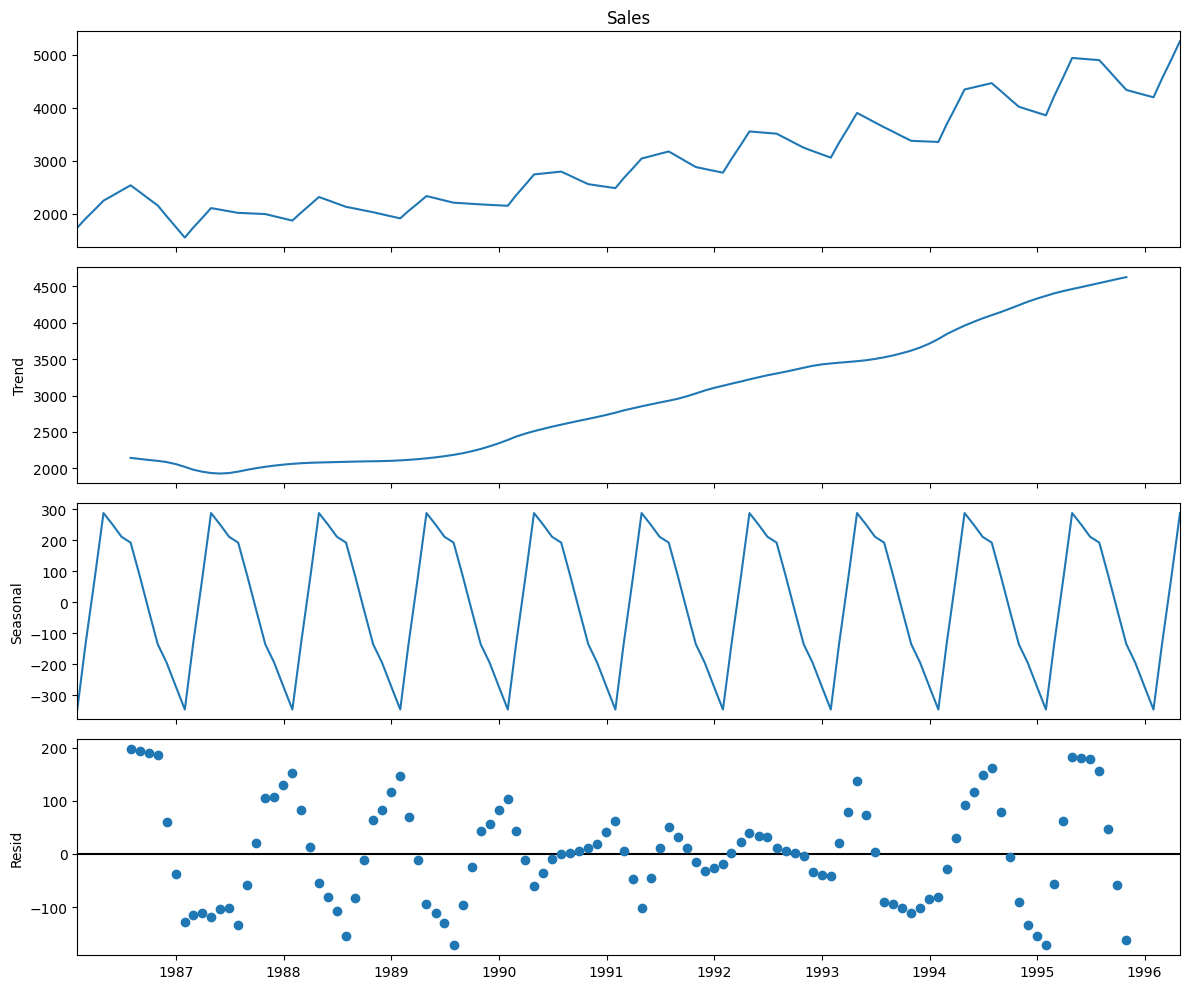

In [36]:
# Additive Seasonal Decomposition
decompose_ts_add = seasonal_decompose(interpolated_month.Sales, period=12, model='additive')
with plt.rc_context():
    plt.rc("figure", figsize=(12,10))
    decompose_ts_add.plot()
    plt.show()

 **Observed** - Actual data
 **Trend** - Increasing or decreasing trend.
 **Seasonal** -
    * Varies from +50 to -50 with the mean 0.
    * Each cycle represents each year trend.
    * The value in the Y-axis has to be added to the Trend plot value to get the actual value of that year. E.g.:- For the year 1950 Nov, the seasonal value is +50 and the trend value is 100. Hence, teh actual value(passengers number) will (seasonal+Trend) value = 50+100 = 150.
**Residual** - It is the noise pattern of the time series data for each year, which was not captured by the two components - Trend and Seasonality. Residual is the left over after decomposition of the two major components (Trend and Seasonality)

# Multiplicative Seasonal Decomposition

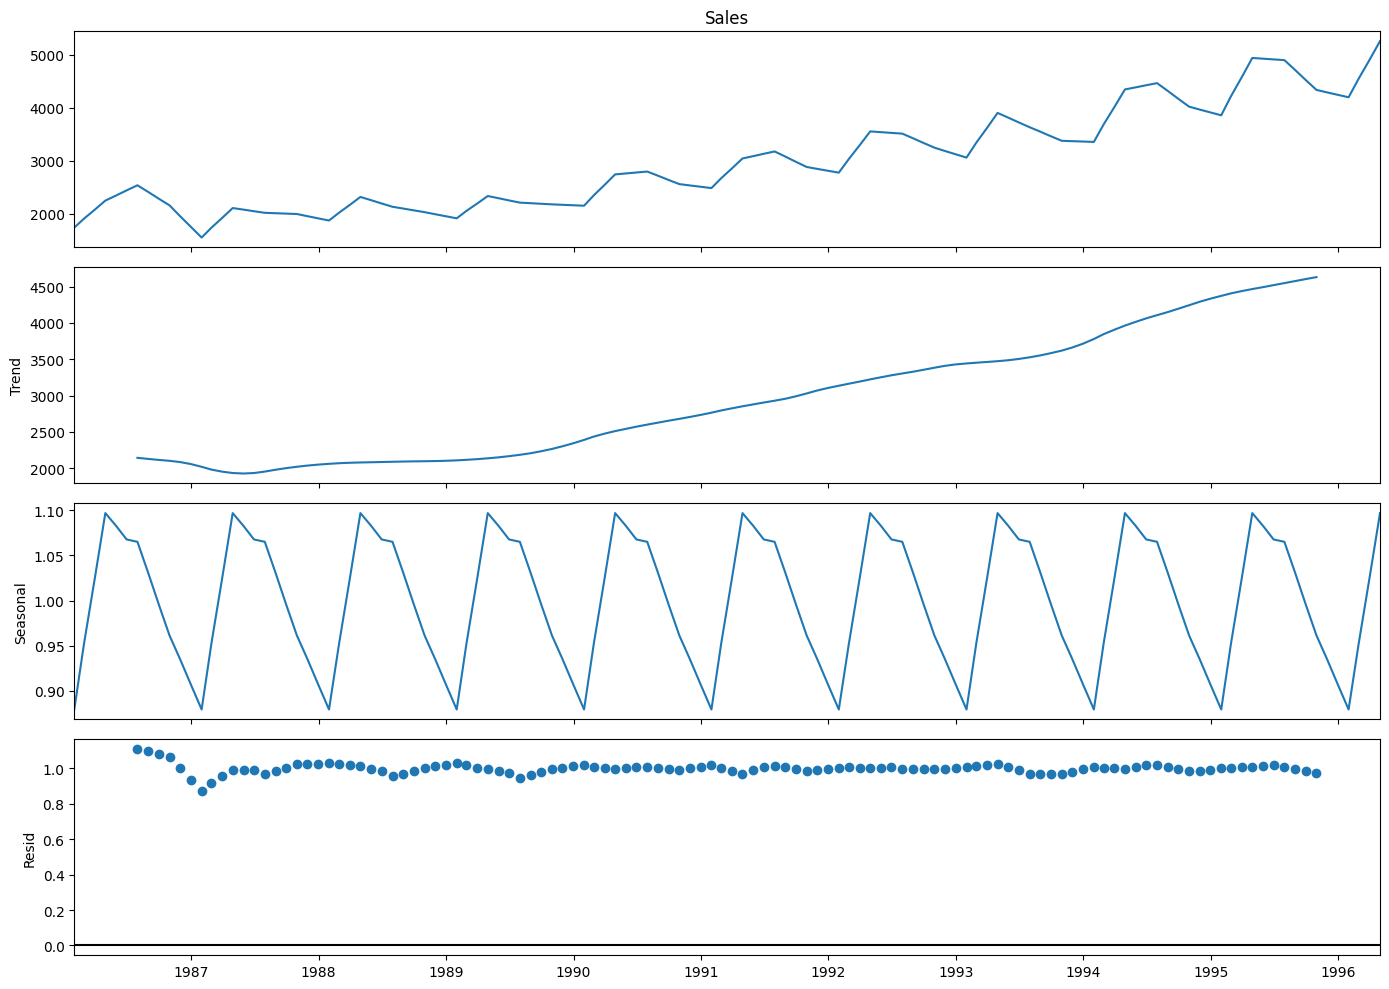

In [37]:
decompose_ts_add = seasonal_decompose(interpolated_month.Sales, period=12, model='multiplicative')
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

### Varies from 0.8 to 1.2, the value in the Y-axis has to be multiplied to the Trend plot value to get the actual value of that year. E.g.:- For the year 1950 Nov, the seasonal value is 1.2 and the trend value is 100. Hence, the actual value(passengers number) will (seasonal X Trend) value = 1.2 X 100 = 120.

In [38]:
# Splitting Train and Test Data
train_data = interpolated_month[:100]
test_data = interpolated_month[100:]

In [39]:
print('Train :',train_data.index.min(),train_data.index.max(),'\n',
'Test :',test_data.index.min(),test_data.index.max())

Train : 1986-01-31 00:00:00 1994-04-30 00:00:00 
 Test : 1994-05-31 00:00:00 1996-04-30 00:00:00


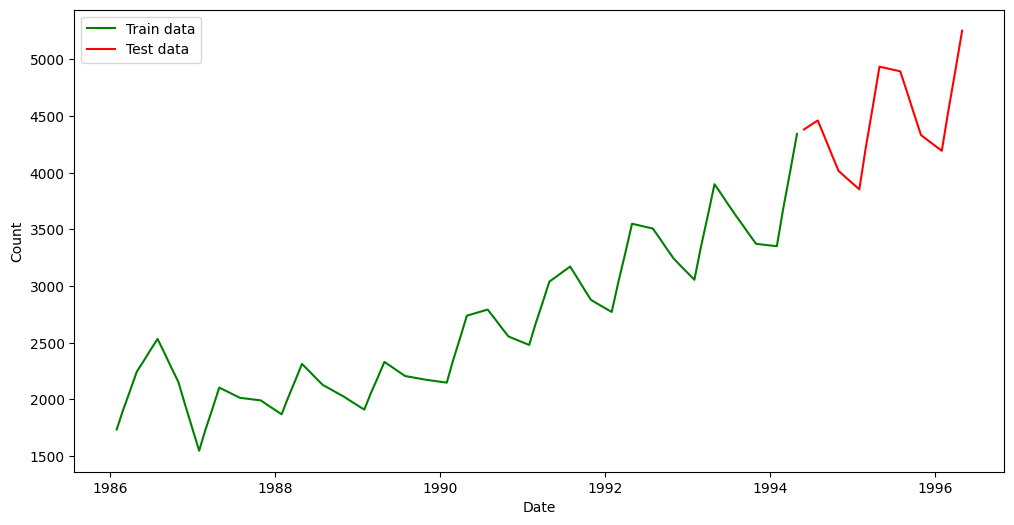

In [40]:
plt.figure(figsize=(12,6))
plt.xlabel('Date')
plt.ylabel('Count')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'red', label='Test data')
plt.legend()
plt.show()

In [41]:
# Evaluation Metric MAPE
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

# Exponential Methods


In [42]:
# Simple Exponential Method
# Using Forecast Attribute
ses_model = SimpleExpSmoothing(train_data['Sales']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Sales))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 6.6197194272254025 
 Train Root Mean Squared Error = 129.37951431349904 
 Test Root Mean Squared Error  = 381.95422355078995


# Using Predict Attribute

In [43]:
ses_model = SimpleExpSmoothing(train_data['Sales']).fit(optimized=True)
test_pred_ses = ses_model.predict(start = test_data.index[0],end = test_data.index[-1])
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test_data.Sales))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train_data))
mape_ses = MAPE(test_pred_ses,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 6.6197194272254025 
 Train Root Mean Squared Error = 129.37951431349904 
 Test Root Mean Squared Error  = 381.95422355078995


# Difference between Predict and Forecast attribute

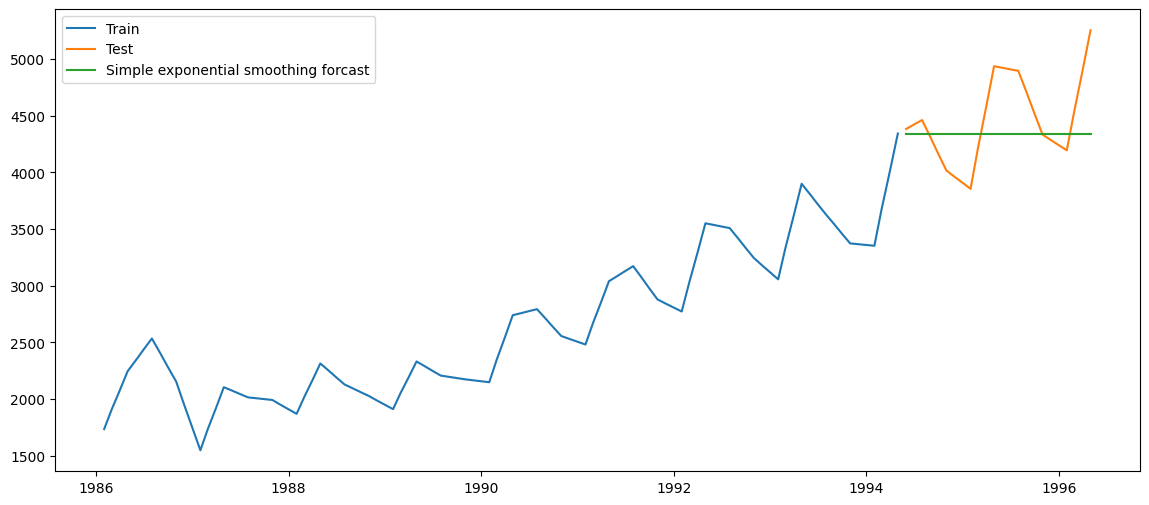

In [44]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

### No seasonality captures. Most recent observation gets higher weightages than the older ones for forecasting.

# Holt method (Double Exponential)

In [45]:
# Captures both Level and Trend .
dexp_model  = Holt(train_data).fit(optimized=True)
test_pred_dexp = dexp_model.forecast(24)
train_pred_dexp = dexp_model.fittedvalues
test_rmse_dexp = sqrt(mean_squared_error(test_pred_dexp,test_data.Sales))
train_rmse_dexp = sqrt(mean_squared_error(train_pred_dexp,train_data))
mape_dexp = MAPE(test_pred_dexp,test_data.Sales)
print('Simple Exponential Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_dexp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_dexp),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_dexp))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error   = 89.49315970529857 
 Train Root Mean Squared Error = 108.70855310404667 
 Test Root Mean Squared Error  = 4549.832544798637


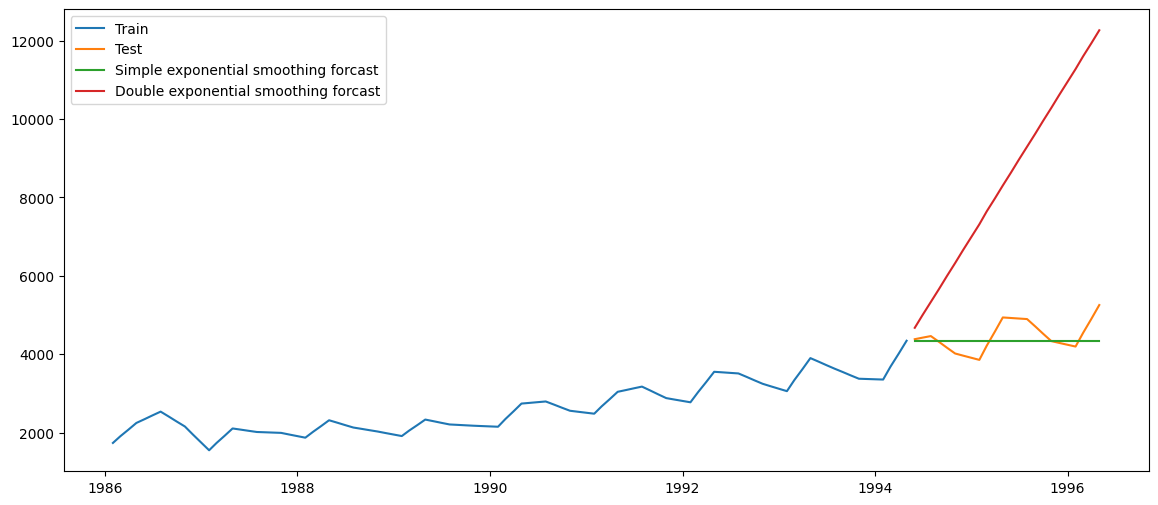

In [46]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.legend(loc='best')
plt.show()

### We can see that we are able to capture the trend of the data but the level is on another level. We were not able to capture the seasonality.

# Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)


In [47]:
# Captures Level, Trend and Seasonality.
texp_add_model  = ExponentialSmoothing(train_data,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_ad_texp = texp_add_model.forecast(24)
train_pred_ad_texp = texp_add_model.fittedvalues
test_rmse_ad_texp = sqrt(mean_squared_error(test_pred_ad_texp,test_data.Sales))
train_rmse_ad_texp = sqrt(mean_squared_error(train_pred_ad_texp,train_data))
mape_ad_texp = MAPE(test_pred_ad_texp,test_data.Sales)
print('Triple Exponential with Additive Trend and Seosonality Method Evaluation',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_texp),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ad_texp))

Triple Exponential with Additive Trend and Seosonality Method Evaluation 
 Mean Absolute Percent Error   = 36.41123890011746 
 Train Root Mean Squared Error = 45.47286658201399 
 Test Root Mean Squared Error  = 1866.7387228355794


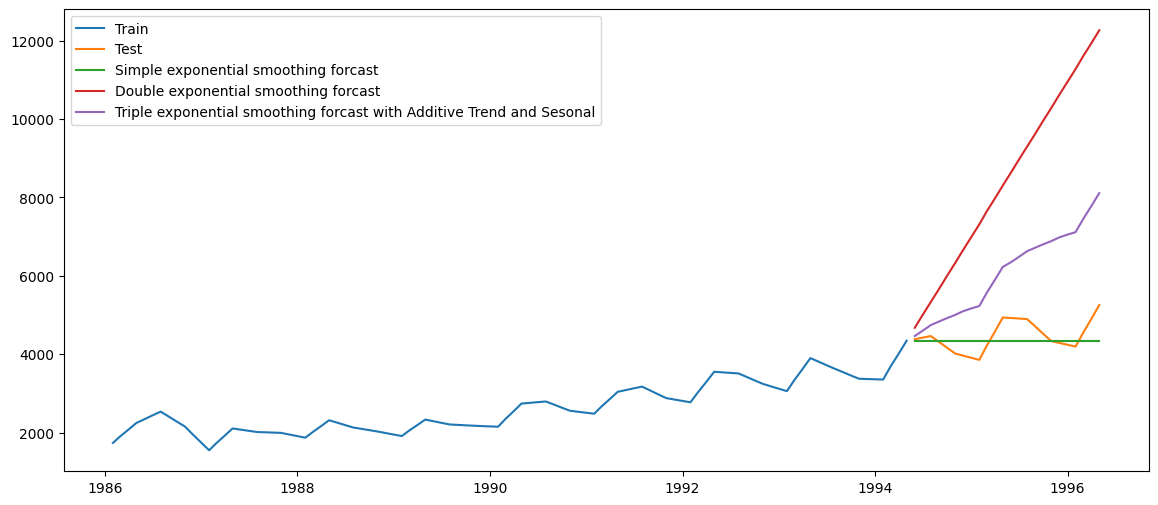

In [48]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

### It captures the trend, which we can see that the forecasted values are higher level than the test level. It also captures the seasonality. The peak of the forecasted value is higher than the actual.

# Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)

In [49]:
texp_mul_ad_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_mul_ad_texp = texp_mul_ad_model.forecast(24)
train_pred_mul_ad_texp = texp_mul_ad_model.fittedvalues
test_rmse_mul_ad_texp = sqrt(mean_squared_error(test_pred_mul_ad_texp,test_data.Sales))
train_rmse_mul_ad_texp = sqrt(mean_squared_error(train_pred_mul_ad_texp,train_data))
mape_mul_ad_texp = MAPE(test_pred_mul_ad_texp,test_data.Sales)
print('Triple Exponential Method with Multiplicative Seasonality and Additive Trend',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_mul_ad_texp),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_ad_texp),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_mul_ad_texp))

Triple Exponential Method with Multiplicative Seasonality and Additive Trend 
 Mean Absolute Percent Error   = 3.9247674882738792 
 Train Root Mean Squared Error = 40.749349630829144 
 Test Root Mean Squared Error  = 224.75363426131906


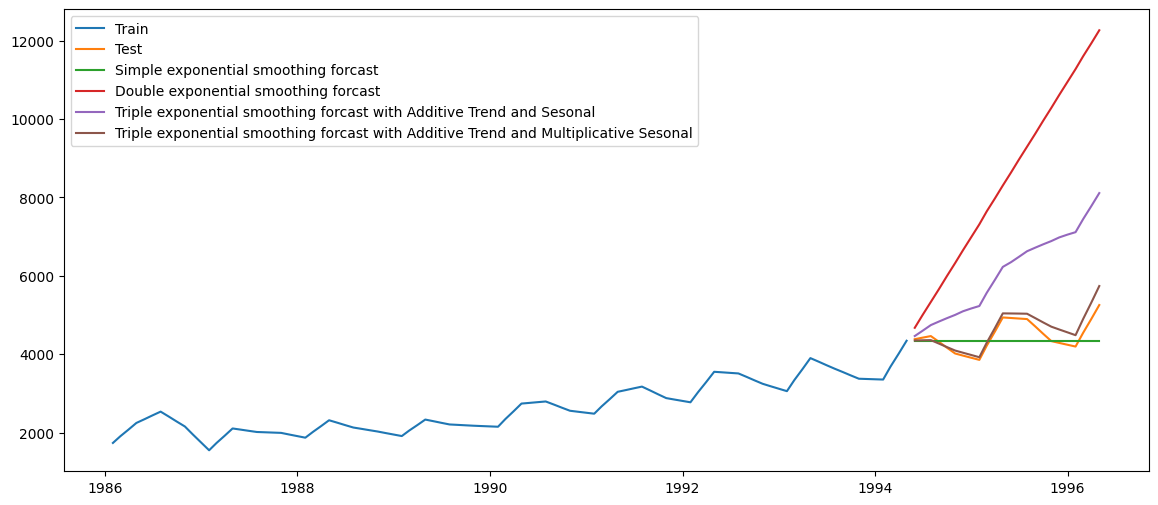

In [50]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

### We can see that the errors have reduced drastically once we are able to capture the level, trend and seasonality altogether.

# Holts winter exponential smoothing with Additive seasonality and multiplicative trend (Triple Exponential)

In [51]:
texp_ad_mul_model  = ExponentialSmoothing(train_data,seasonal="add",trend="mul",seasonal_periods=12).fit(smoothing_level=0.1, smoothing_slope=0.5)
test_pred_ad_mul_texp  = texp_ad_mul_model.forecast(24)
train_pred_ad_mul_texp  = texp_ad_mul_model.fittedvalues
test_rmse_ad_mul_texp  = sqrt(mean_squared_error(test_pred_ad_mul_texp ,test_data.Sales))
train_rmse_ad_mul_texp  = sqrt(mean_squared_error(train_pred_ad_mul_texp ,train_data))
mape_ad_mul_texp  = MAPE(test_pred_ad_mul_texp,test_data.Sales)
print('Triple Exponential Method with Additive Seasonality and Multiplicative Trend',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_ad_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ad_mul_texp ),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_ad_mul_texp ))

Triple Exponential Method with Additive Seasonality and Multiplicative Trend 
 Mean Absolute Percent Error   = 5.213801653194689 
 Train Root Mean Squared Error = 169.73027433368938 
 Test Root Mean Squared Error  = 269.62466180973115


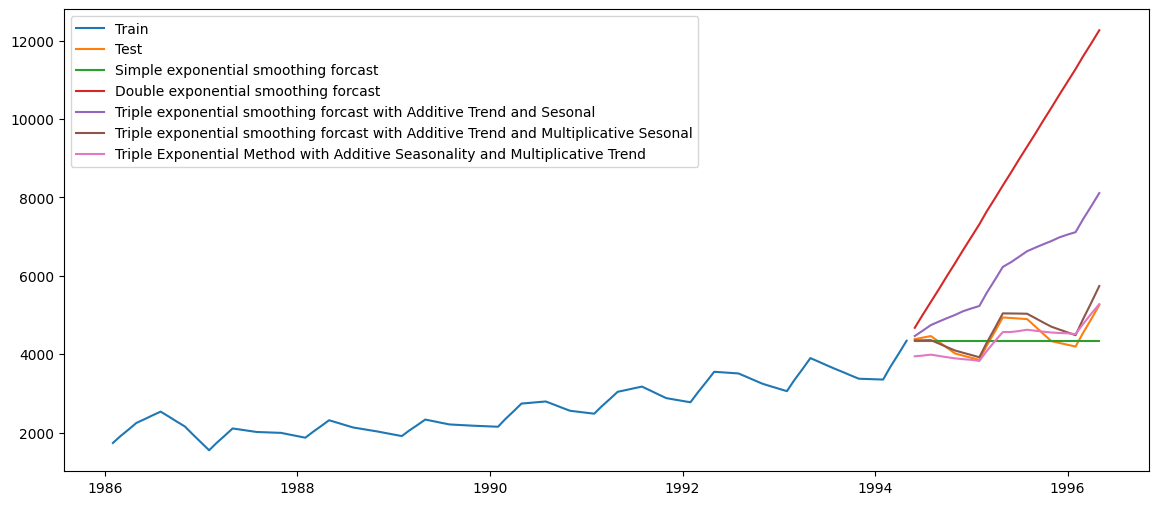

In [52]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.legend(loc='best')
plt.show()

# Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)

In [53]:
texp_mul_model  = ExponentialSmoothing(train_data,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_mul_texp  = texp_mul_model.forecast(24)
train_pred_mul_texp  = texp_mul_model.fittedvalues
test_rmse_mul_texp  = sqrt(mean_squared_error(test_pred_mul_texp ,test_data.Sales))
train_rmse_mul_texp  = sqrt(mean_squared_error(train_pred_mul_texp ,train_data))
mape_mul_texp  = MAPE(test_pred_mul_texp,test_data.Sales)
print('Triple Exponential Method with multiplicative Trend and Seasonality',"\n",\
'Mean Absolute Percent Error   = {}'.format(mape_mul_texp ),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_mul_texp ),"\n",
'Test Root Mean Squared Error  = {}'.format(test_rmse_mul_texp ))

Triple Exponential Method with multiplicative Trend and Seasonality 
 Mean Absolute Percent Error   = 5.878529181011106 
 Train Root Mean Squared Error = 39.927741761306415 
 Test Root Mean Squared Error  = 343.4061217974434


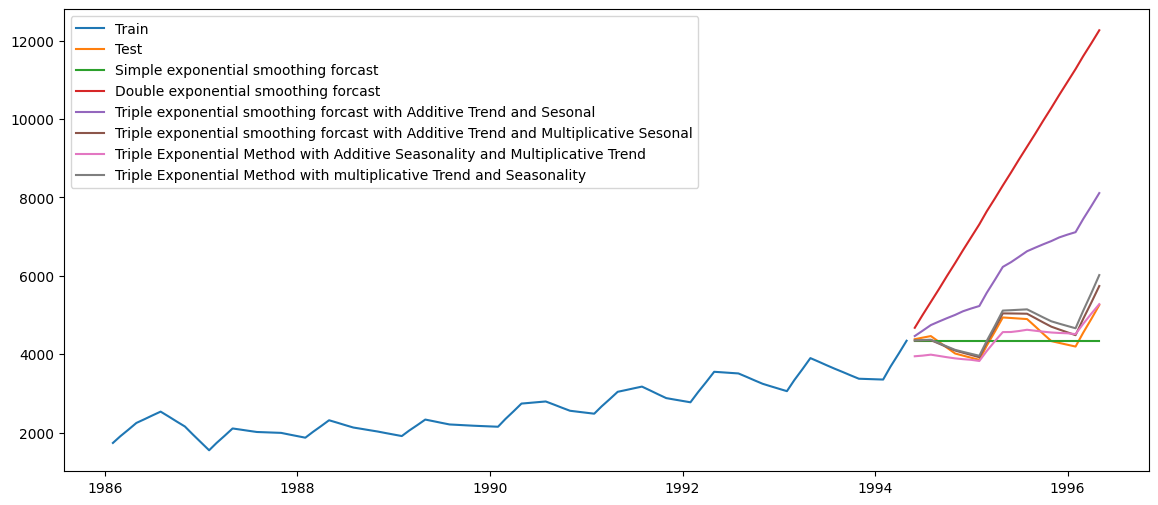

In [54]:
plt.figure(figsize=(14,6))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forcast')
plt.plot(test_pred_dexp, label='Double exponential smoothing forcast')
plt.plot(test_pred_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Sesonal')
plt.plot(test_pred_mul_ad_texp, label='Triple exponential smoothing forcast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_ad_mul_texp, label='Triple Exponential Method with Additive Seasonality and Multiplicative Trend')
plt.plot(test_pred_mul_texp, label='Triple Exponential Method with multiplicative Trend and Seasonality')
plt.legend(loc='best')
plt.show()

# Comparing the results 

In [55]:
Evaluation = {"Models":pd.Series(["Simple_Exp","Double_Exp","Triple_Exp_Add","Triple_Exp_Mul_Add","Triple_Exp_Add_Mul","Triple_Exp_Mul"]),
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_dexp,train_rmse_ad_texp,train_rmse_mul_ad_texp,train_rmse_ad_mul_texp,train_rmse_mul_texp]),
        "Test_MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp]),
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

,Models,Train_RMSE,Test_MAPE(%),Test_RMSE_Values
0,Triple_Exp_Mul_Add,40.749350,3.924767,224.753634
1,Triple_Exp_Add_Mul,169.730274,5.213802,269.624662
2,Triple_Exp_Mul,39.927742,5.878529,343.406122
3,Simple_Exp,129.379514,6.619719,381.954224
4,Triple_Exp_Add,45.472867,36.411239,1866.738723
5,Double_Exp,108.708553,89.493160,4549.832545


# Visualizing Models Performance

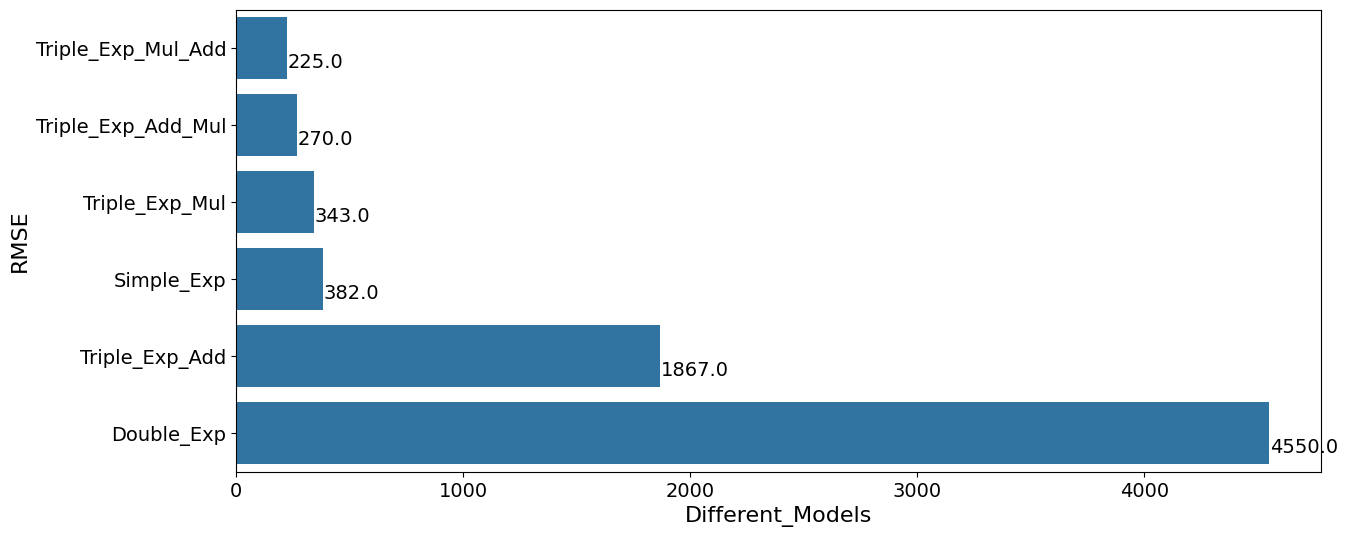

In [56]:
f, axe = plt.subplots(1,1, figsize=(14,6))
sns.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v), fontsize= 14)
plt.show()

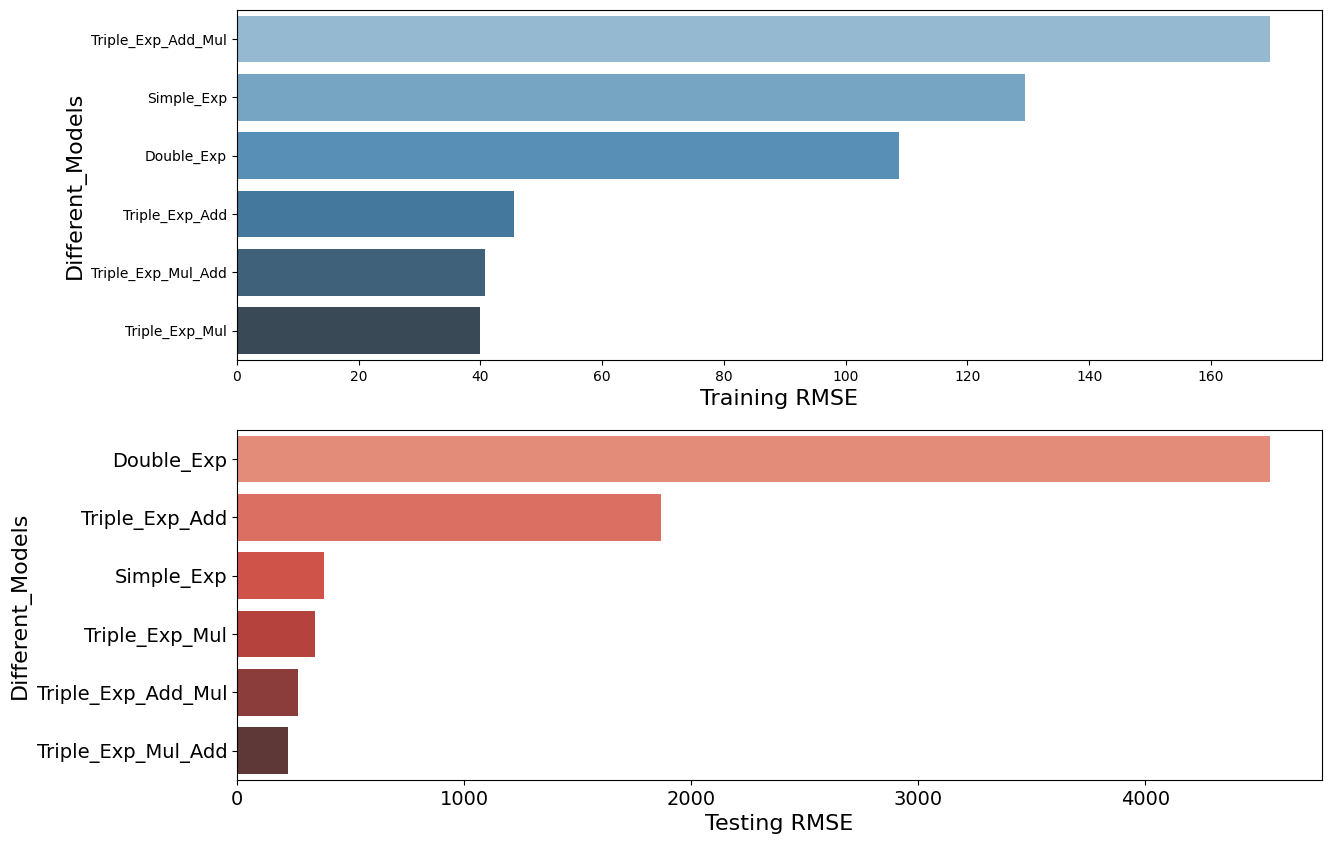

In [57]:
f, axes = plt.subplots(2,1, figsize=(14,10))
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

train_rmse = table_evaluation.sort_values(by=['Train_RMSE'], ascending=False)

sns.barplot(x='Train_RMSE', y='Models', data = train_rmse, palette='Blues_d', ax = axes[0])
axes[0].set_xlabel('Training RMSE', size=16)
axes[0].set_ylabel('Different_Models', size=16)

test_rmse = table_evaluation.sort_values(by=['Test_RMSE_Values'], ascending=False)

sns.barplot(x='Test_RMSE_Values', y='Models', data = test_rmse, palette='Reds_d', ax = axes[1])
axes[1].set_xlabel('Testing RMSE', size=16)
axes[1].set_ylabel('Different_Models', size=16)

plt.show()

# Autoregressive Integrated Moving Averages (ARIMA)

### Stationary vs Non-stationary Time Series
### Test of Stationarity

In [58]:
# As we have quarterly data the window size for moving average is equal to 4
def test_stationarity(timeseries):
    
    # Determine rolling statistics
    movingAverage = timeseries.rolling(window=4).mean()
    movingSTD = timeseries.rolling(window=4).std()
    
    # Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    # Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Sales'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# Augmented Dicky Fuller Test

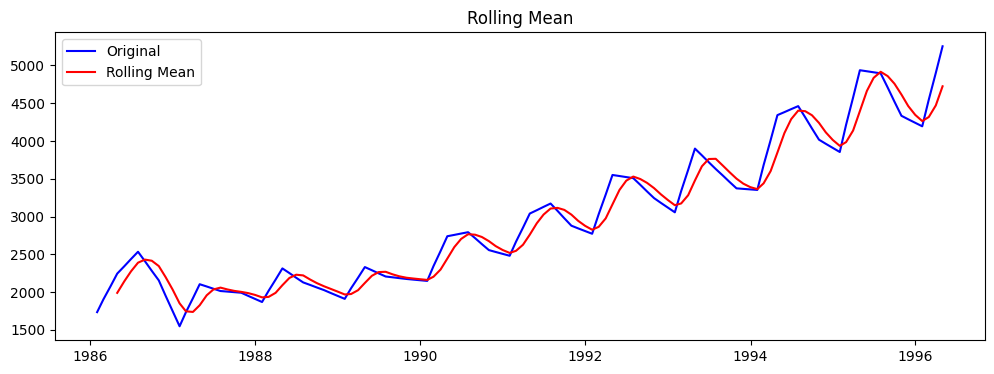

Results of Dickey Fuller Test:
Test Statistic                   0.572599
p-value                          0.986920
#Lags Used                      10.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


In [59]:
plt.figure(figsize=(12,4))
sales= pd.DataFrame()
sales['Sales'] = interpolated_month[['Sales']]
test_stationarity(sales)

In [60]:
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [61]:
adf_test(sales.Sales)

Fail to reject the null hypothesis
Data is non-stationary


# Feature Scaling (Transformations)


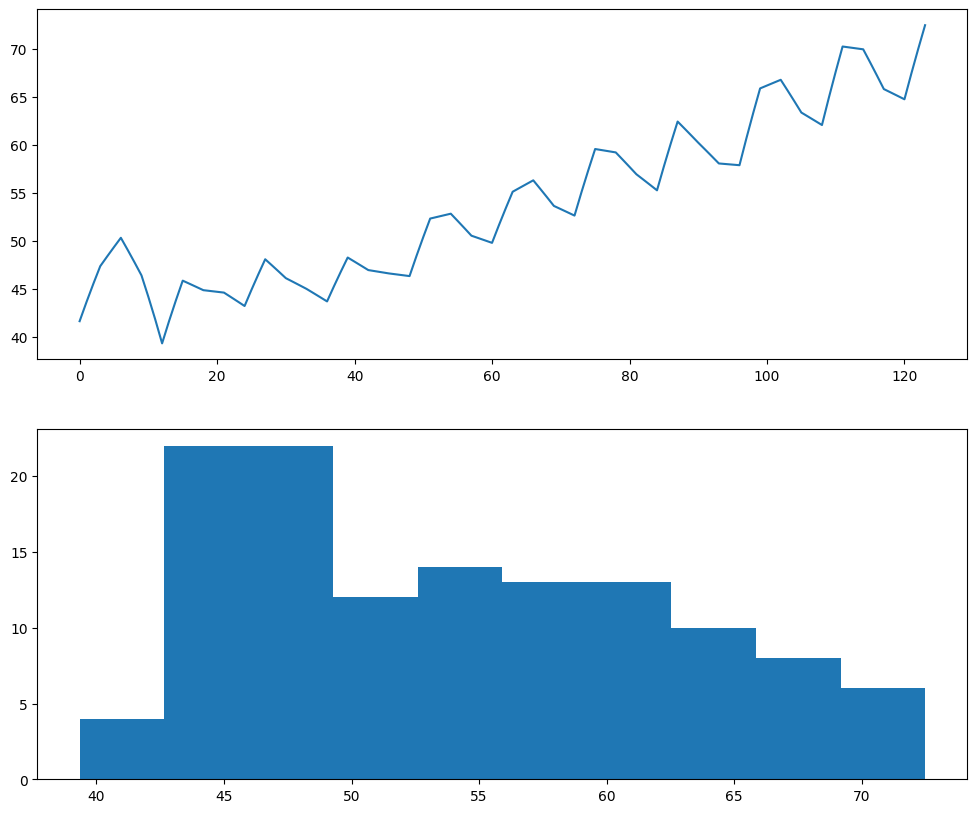

In [112]:
# Square Root Transform
square_root = pd.DataFrame()
square_root = interpolated_month[['Sales']]
square_root['Sales'] = np.sqrt(square_root.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(square_root['Sales'])

# Histogram
plt.subplot(212)
plt.hist(square_root['Sales'])
plt.show()

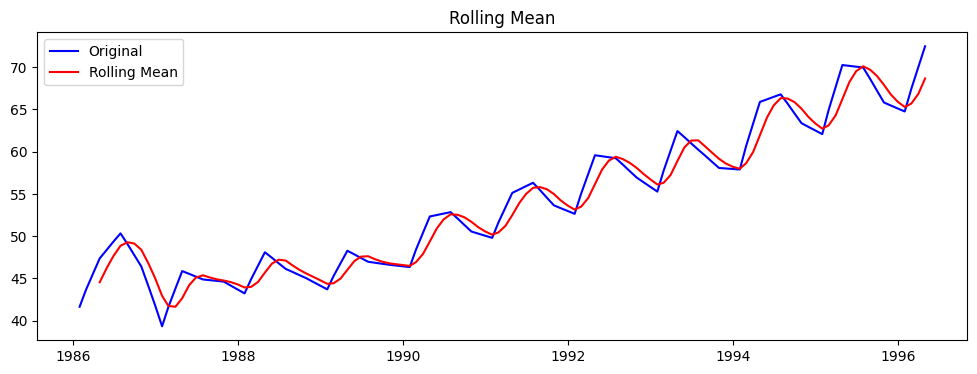

Results of Dickey Fuller Test:
Test Statistic                   0.728012
p-value                          0.990381
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [63]:
plt.figure(figsize=(12,4))
test_stationarity(square_root)

In [64]:
adf_test(square_root.Sales)

Fail to reject the null hypothesis
Data is non-stationary


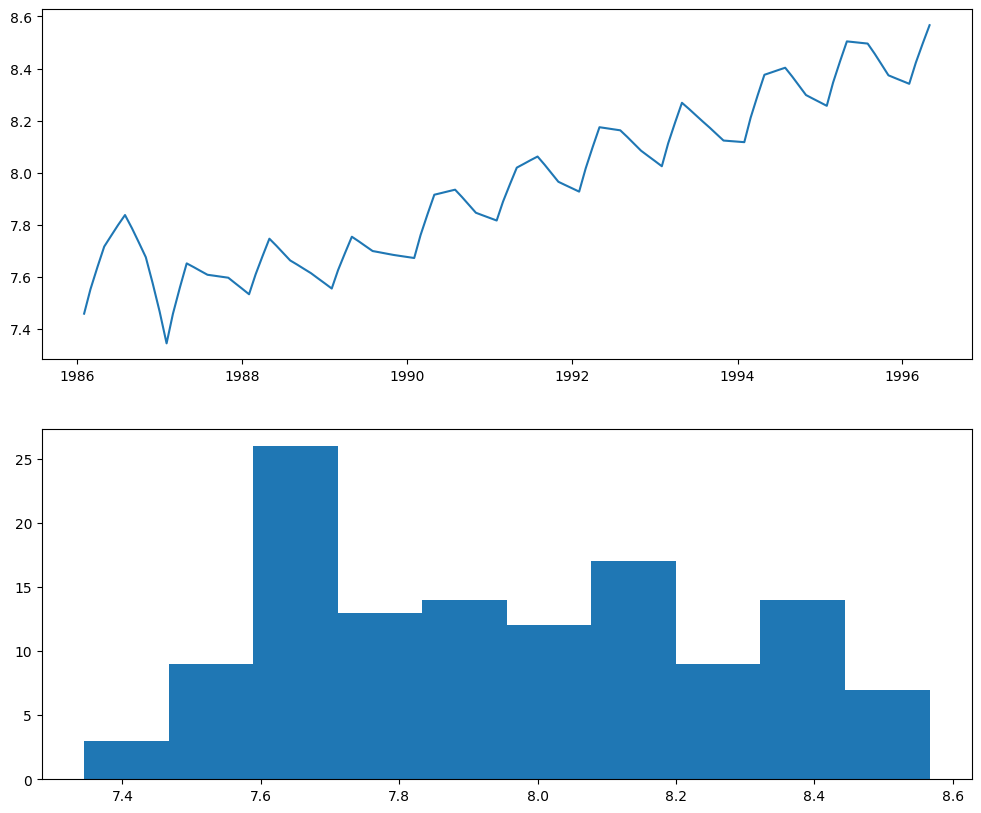

In [65]:
# Log Transform
log = pd.DataFrame()
log = interpolated_month[['Sales']]
log['Sales'] = np.log(log.Sales)

# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Sales'])

# Histogram
plt.subplot(212)
plt.hist(log['Sales'])
plt.show()

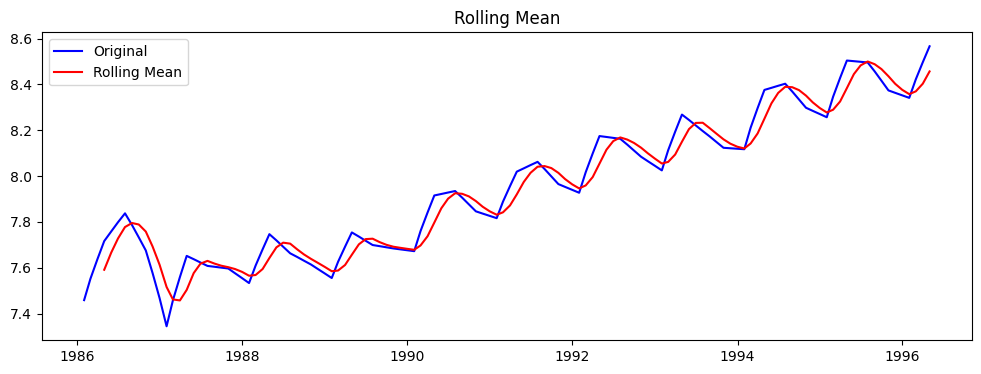

Results of Dickey Fuller Test:
Test Statistic                   0.451508
p-value                          0.983322
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [66]:
plt.figure(figsize=(12,4))
test_stationarity(log)

In [67]:
adf_test(log.Sales)

Fail to reject the null hypothesis
Data is non-stationary


### Hence, the Time series data is Non-Stationary

# Converting Non-Stationary Time Series into Stationary


,Sales
Date,
1986-01-31,7.458663
1986-02-28,7.552170
1986-03-31,7.637676
1986-04-30,7.716443
1986-05-31,7.758437


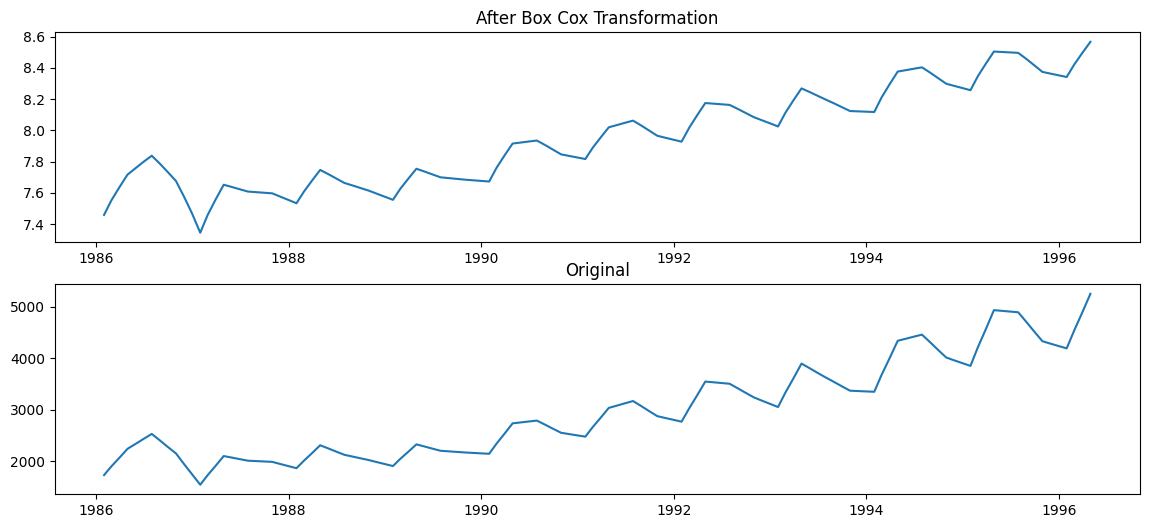

In [68]:
# Box Cox Transformation
data_boxcox = pd.DataFrame()
data_boxcox['Sales'] = pd.Series(boxcox(interpolated_month['Sales'], lmbda=0), interpolated_month.index)
display(data_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,6),)
axis[0].plot(data_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(interpolated_month, label='original')
axis[1].set_title('Original')
plt.show()

### We can see the variance became almost constant after the transformation. Both in the earlier and later years the variance is almost similar. But we can see that still the series has an upward trend. So, the mean is not constant yet. Hence, we need to do Differencing for making the mean constant.

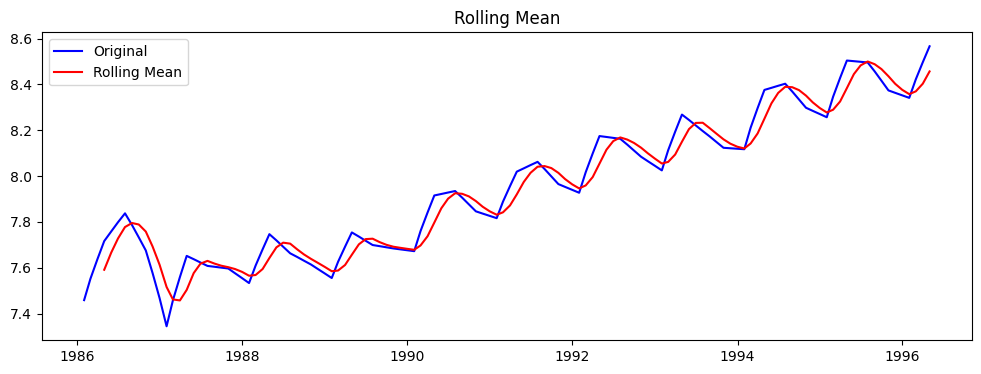

Results of Dickey Fuller Test:
Test Statistic                   0.451508
p-value                          0.983322
#Lags Used                      13.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [69]:
plt.figure(figsize=(12,4))
test_stationarity(data_boxcox)

In [70]:
adf_test(data_boxcox)

Fail to reject the null hypothesis
Data is non-stationary


# Differencing of the Box-Cox Transformation

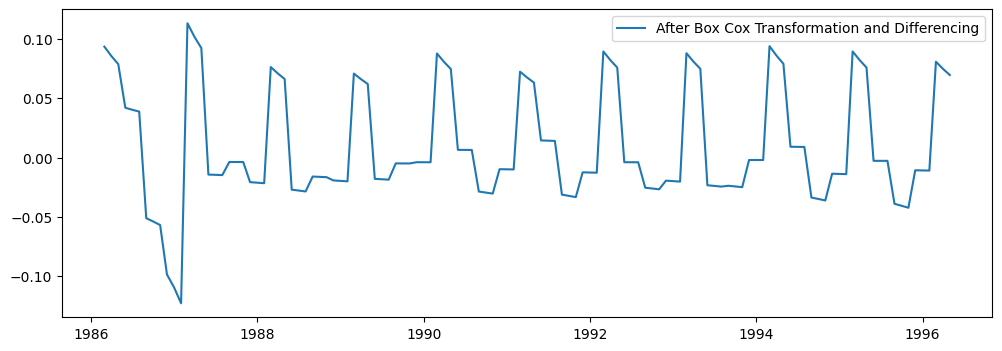

In [71]:
data_boxcox_diff = data_boxcox - data_boxcox.shift()
data_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(data_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

### We can see that there is no trend (upward or downward) after differencing on the Box Cox transformation. It is a horizontal trend. The mean became constant. The mean is zero. Also, the variance is almost constant.

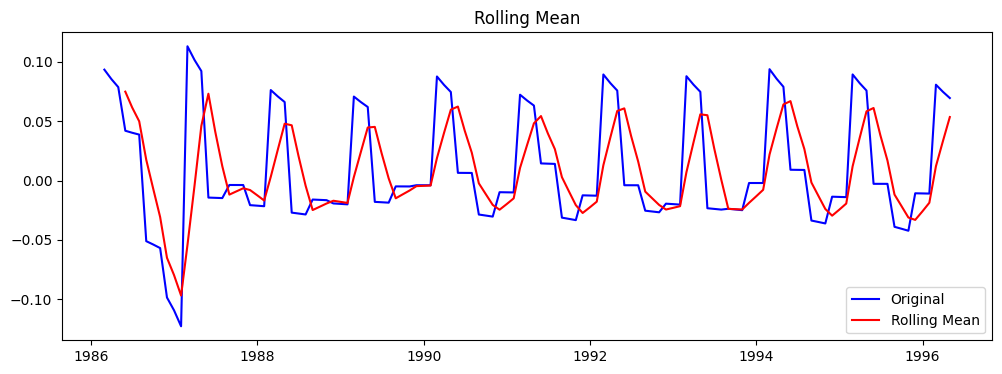

Results of Dickey Fuller Test:
Test Statistic                  -3.030060
p-value                          0.032181
#Lags Used                      12.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64


In [72]:
plt.figure(figsize=(12,4))
test_stationarity(data_boxcox_diff)

In [73]:
adf_test(data_boxcox_diff.Sales)

Reject the null hypothesis
Data is stationary


### Finally, Our Series is now stationary for AR Forecasting
# Building The Time Series Forecasting with Optimal Value using ARIMA

In [74]:
train_data_boxcox = data_boxcox[:100]
test_data_boxcox = data_boxcox[100:]
train_data_boxcox_diff = data_boxcox_diff[:99]
test_data_boxcox_diff = data_boxcox_diff[99:]

# ARIMA Hyperparameter Tuning

In [75]:
# Grid search ARIMA parameters for a time series
# Evaluate an ARIMA model for a given order (p,d,q) and return RMSE

def evaluate_arima_model(X, arima_order):

# Prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

# Make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        
# Calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# Evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [76]:
# Evaluate parameters
p_values = range(0,5)
d_values = range(0,5)
q_values = range(0,5)
evaluate_models(train_data_boxcox_diff.Sales, p_values, d_values, q_values)

Best ARIMA(3, 0, 2) RMSE=0.028


# Inverse transformation of the Box-Cox Differencing

In [77]:
model = ARIMA(train_data_boxcox_diff, order=(3, 0, 2))
model_fit = model.fit()
y_hat_ar = data_boxcox_diff.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())

# We did differencing. So we need to revert it by adding the consecutive observations.
# For that we are using cumsum() method
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].cumsum()

# We removed the first observations after differencing as it was null. Hence, adding the first observation back.
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].add(data_boxcox.Sales[0])

# Now doing the reverse transformation 
# We have done Box Cox Log Log transformation with lambda = 0
# Hence, we have to the exponential as it is the reverse of the log.
y_hat_ar['arima_forecast'] = np.exp(y_hat_ar['arima_forecast'])

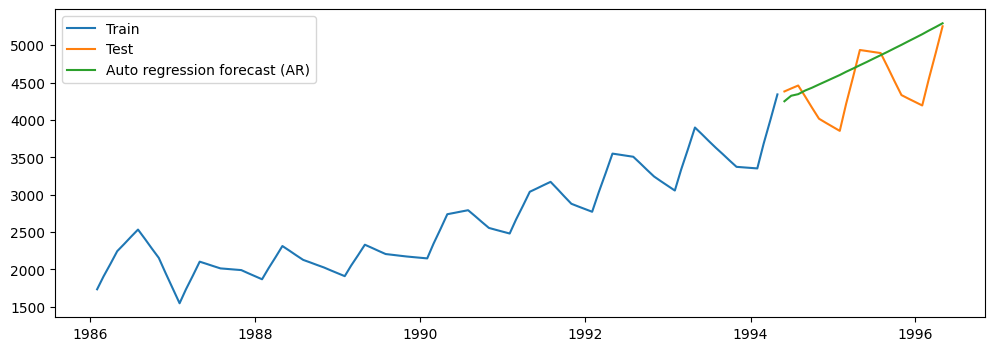

In [78]:
plt.figure(figsize=(12,4))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test_data.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

### We can see that we have done moderately well. No Seasonality captured. Only Trend has been captured

# Model Evaluation


In [79]:
# RMSE (Root Mean Squared Error)
rmse_arima = np.sqrt(mean_squared_error(test_data.Sales, y_hat_ar['arima_forecast'][test_data.index.min():])).round(2)
rmse_arima

471.81

In [80]:
# MAPE (Mean Absolute Percent Error)
mape_arima = round(np.mean(np.abs((test_data.Sales - y_hat_ar['arima_forecast'][test_data.index.min():])/test_data.Sales)*100),2)
mape_arima

8.83

### We can see that AR model has done reasonably good job but not better than Holt's method. We souldn't compare it with Holt's method. Because Holt's method captures seasonality

# Analysing the Residuals


In [81]:
# The mean of the Residual should be zero or close to Zero
model_residual = model_fit.resid
model_residual.mean()

0.00018718437725183824

# Residuals must be stationary

In [82]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


# No autocorrelation between residuals

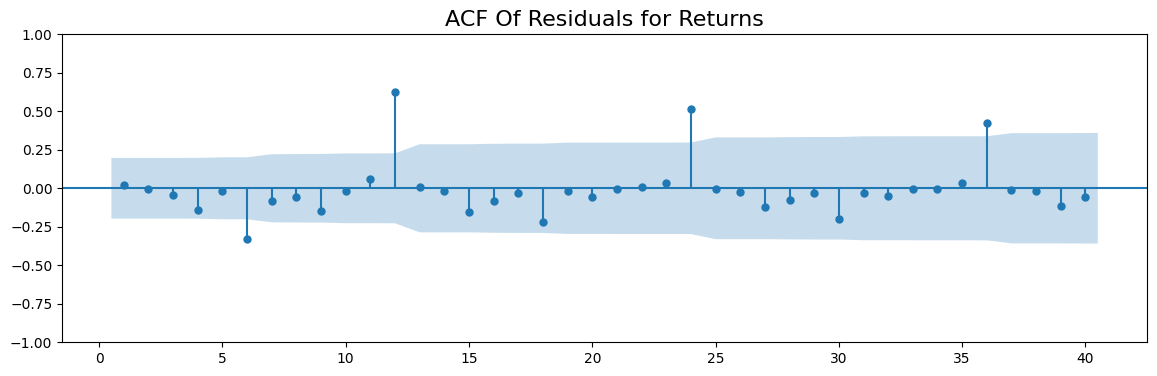

In [83]:
plt.rcParams["figure.figsize"] = (14,4)
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=16)
plt.show()

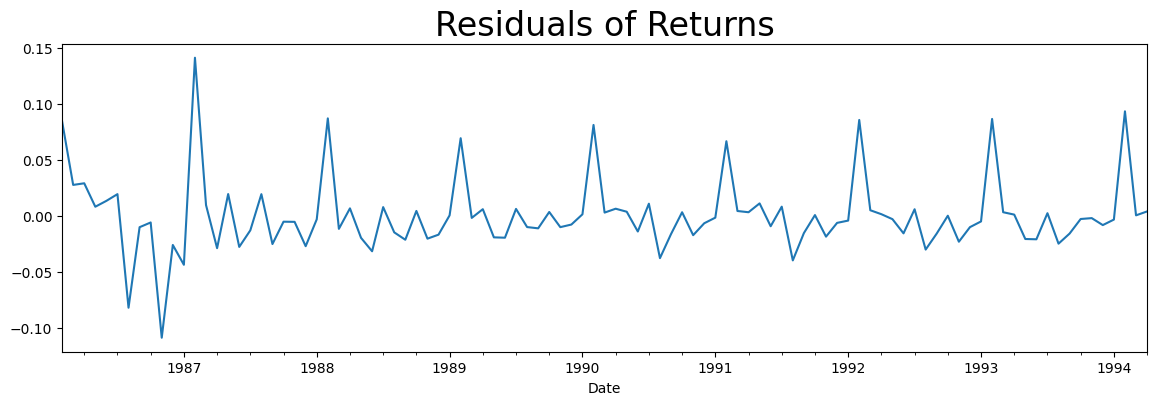

In [84]:
# Residuals must be random
model_residual.plot(figsize=(14,4))
plt.title("Residuals of Returns", size=24)
plt.show()

# Seasonal Auto Regressive Integrated Moving Average (SARIMA)

### We are only passing the Box Cox because the ARIMAX will perform the differencing internally


In [85]:
# seasonal_order P=1, Q=1, D=1 and m=12 || m=12 . Because the seasonality is monthly.
model = SARIMAX(train_data_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit= model.fit()
y_hat_sarima = data_boxcox_diff.copy()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.17311D+00    |proj g|=  3.91193D+00

At iterate    5    f= -2.17466D+00    |proj g|=  1.20889D-01

At iterate   10    f= -2.17607D+00    |proj g|=  2.12448D+00
  ys=-4.681E-05  -gs= 5.394E-04 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f= -2.17656D+00    |proj g|=  3.31143D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f= -2.17656D+00    |proj g|=  1.00863D-01

At iterate   25    f= -2.17657D+00    |proj g|=  4.21698D-02

At iterate   30    f= -2.17677D+00    |proj g|=  3.92479D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31    118      3     1     0   3.925D-02  -2.177D+00
  F =  -2.1767694612126673     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


# Inverse Transformation of the Differencing Box-Cox Transformation

In [86]:
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(data_boxcox_diff.index.min(), data_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

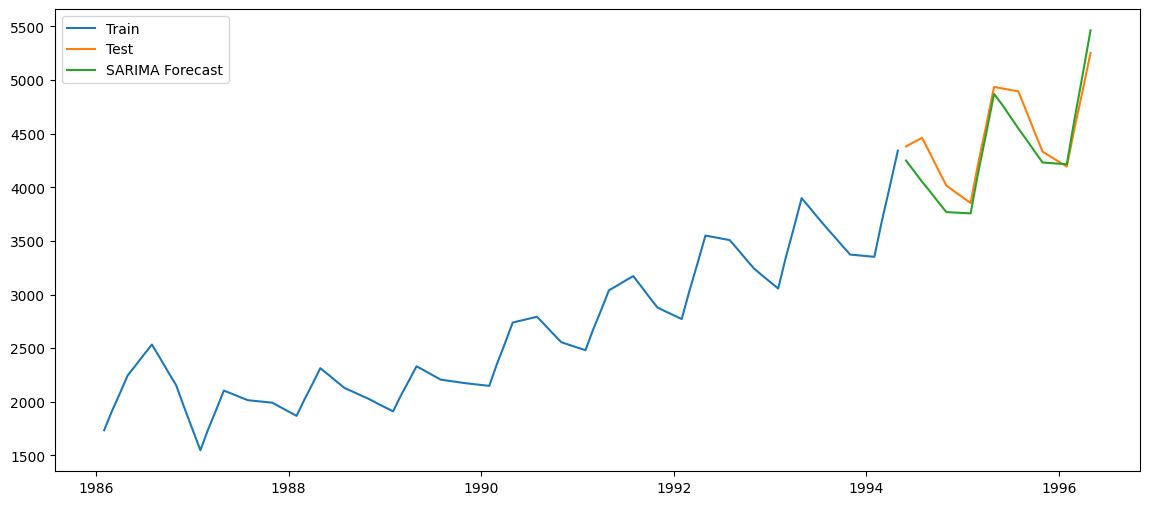

In [87]:
plt.figure(figsize=(14,6))
plt.plot(train_data['Sales'], label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test_data.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

### We can see that we are able to capture the trend and seasonality both.

# Model Evaluation


In [88]:
# RMSE (Root Mean Squared Error)
rmse_sarima = np.sqrt(mean_squared_error(test_data, y_hat_sarima['sarima_forecast'][test_data.index.min():])).round(2)
rmse_sarima

205.94

In [89]:
# MAPE (Mean Absolute Percent Error)
mape_sarima = round(np.mean(np.abs((test_data.Sales - y_hat_sarima['sarima_forecast'][test_data.index.min():])/test_data.Sales)*100),2)
mape_sarima

3.94

### SARIMA method has done reasonably well as it captures seasonality. The performance is comparable with the other methods such as Holt's Winter additive/multiplicative, whcich also captures seasonality.

# Analysing the Residuals


In [90]:
# The mean of the Residual should be zero or close to Zero
model_residual = model_fit.resid
model_residual.mean()

0.037053035757680736

# Residuals must be stationary

In [91]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


# No autocorrelation between residuals

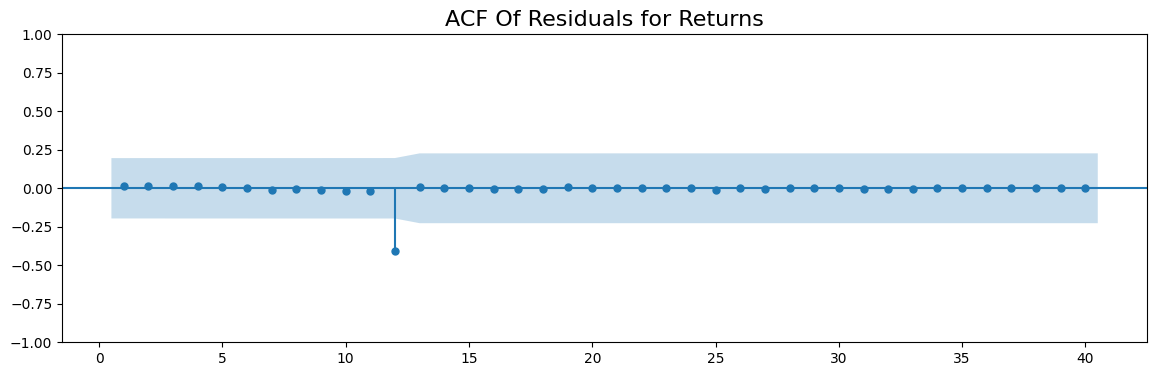

In [92]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals for Returns",size=16)
plt.show()

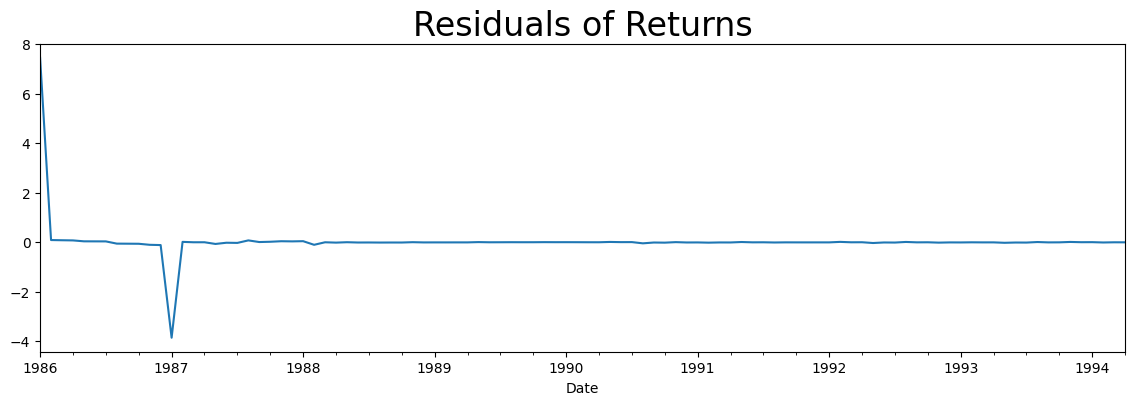

In [93]:
# Residuals must be random
model_residual.plot(figsize=(14,4))
plt.title("Residuals of Returns", size=24)
plt.show()

# Creating model with differente Transformation Technique


In [94]:
# Compareing the results
Evaluation = {"Models":pd.Series(["Simple_Exponential","Double_Exponential","Triple_Exp_Additive","Triple_Exp_Mul_Add","Triple_Exp_Add_Mul","Triple_Exp_Multiplicative","ARIMA","SARIMA"]),
        "MAPE(%)":pd.Series([mape_ses,mape_dexp,mape_ad_texp,mape_mul_ad_texp,mape_ad_mul_texp,mape_mul_texp,mape_arima,mape_sarima]),\
        "RMSE_Values":pd.Series([test_rmse_ses,test_rmse_dexp,test_rmse_ad_texp,test_rmse_mul_ad_texp,test_rmse_ad_mul_texp,test_rmse_mul_texp,rmse_arima,rmse_sarima])}
table_evaluation=pd.DataFrame(Evaluation)
table_evaluation.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

,Models,MAPE(%),RMSE_Values
0,SARIMA,3.940000,205.940000
1,Triple_Exp_Mul_Add,3.924767,224.753634
2,Triple_Exp_Add_Mul,5.213802,269.624662
3,Triple_Exp_Multiplicative,5.878529,343.406122
4,Simple_Exponential,6.619719,381.954224
5,ARIMA,8.830000,471.810000
6,Triple_Exp_Additive,36.411239,1866.738723
7,Double_Exponential,89.493160,4549.832545


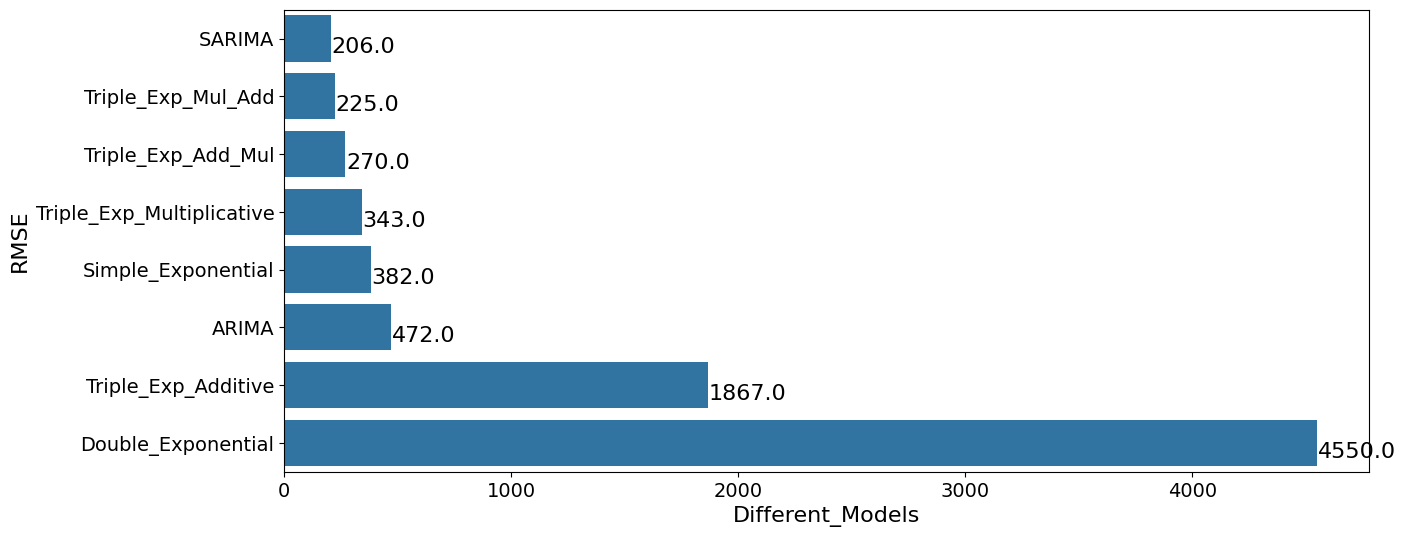

In [95]:
f, axe = plt.subplots(1,1, figsize=(14,6))
sns.barplot(x='RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(np.round(table_evaluation.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v), fontsize= 16)

plt.show()

### The Sarima Model did very well as compared to other methods and Models Even in methods such as Triple Exponential Smoothing (Holts-Winters Method) taking Seasonality as Multiplicative and Trend as Additive gave the second best restult in this case

# Data Pre-processing for Model Driven Techniques


In [96]:
# Creating Dummy Variables of the Categorical Feature Month of Date Time feature
interpolated_month.reset_index(inplace=True)
interpolated_month['t'] = np.arange(1,len(interpolated_month)+1)
interpolated_month['t_squared'] = np.square(interpolated_month.t)
interpolated_month["month"] = interpolated_month.Date.dt.strftime("%b") # month extraction
interpolated_month["year"] = interpolated_month.Date.dt.strftime("%Y") # year extraction
months = pd.get_dummies(interpolated_month['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
cocacola = pd.concat([interpolated_month,months],axis=1)
cocacola['log_sales'] = np.log(cocacola['Sales'])
cocacola

,Date,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
0,1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1,1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
2,1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
3,1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
4,1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,1995-12-31,4240.333333,120,14400,Dec,1995,0,0,0,0,0,0,0,0,0,0,0,1,8.352397
120,1996-01-31,4194.000000,121,14641,Jan,1996,1,0,0,0,0,0,0,0,0,0,0,0,8.341410
121,1996-02-29,4547.000000,122,14884,Feb,1996,0,1,0,0,0,0,0,0,0,0,0,0,8.422223
122,1996-03-31,4900.000000,123,15129,Mar,1996,0,0,1,0,0,0,0,0,0,0,0,0,8.496990


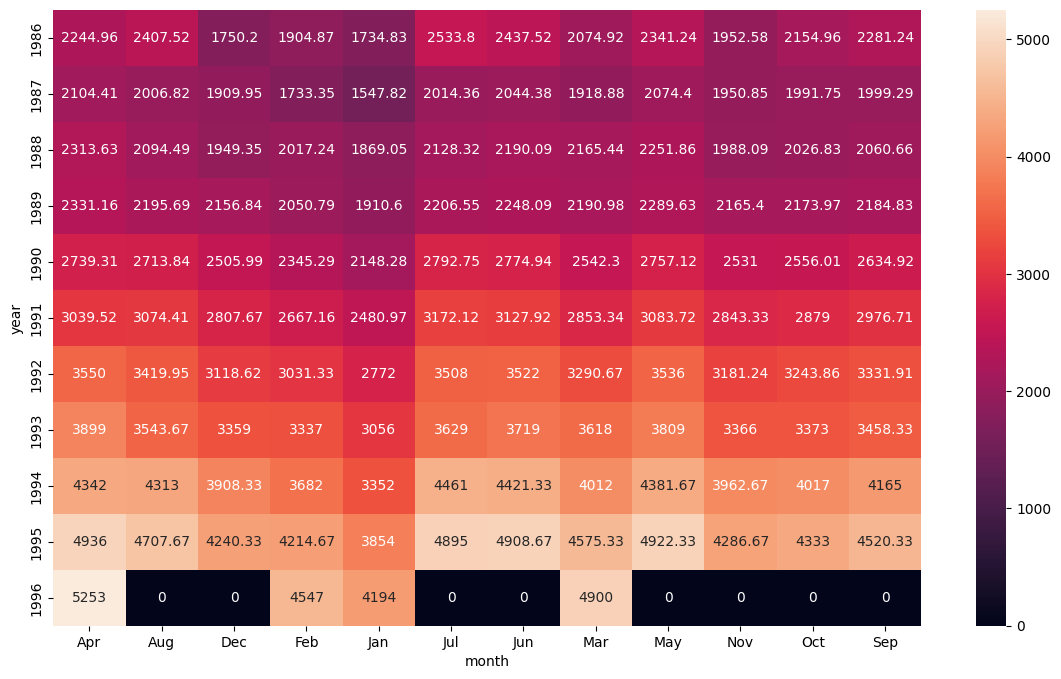

In [97]:
plt.figure(figsize=(14,8))
heatmap_y_month = pd.pivot_table(data=cocacola,values="Sales",index="year",columns="month",aggfunc="mean",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")
plt.show()

# Splitting data into Train and Test


In [98]:
# 70% of data into Train data and rest for Test Data
size = 100

train_data = cocacola.iloc[:size]
test_data = cocacola.iloc[size:]

In [99]:
train_data

,Date,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
0,1986-01-31,1734.827000,1,1,Jan,1986,1,0,0,0,0,0,0,0,0,0,0,0,7.458663
1,1986-02-28,1904.871666,2,4,Feb,1986,0,1,0,0,0,0,0,0,0,0,0,0,7.552170
2,1986-03-31,2074.916332,3,9,Mar,1986,0,0,1,0,0,0,0,0,0,0,0,0,7.637676
3,1986-04-30,2244.960999,4,16,Apr,1986,0,0,0,1,0,0,0,0,0,0,0,0,7.716443
4,1986-05-31,2341.242330,5,25,May,1986,0,0,0,0,1,0,0,0,0,0,0,0,7.758437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1993-12-31,3359.000000,96,9216,Dec,1993,0,0,0,0,0,0,0,0,0,0,0,1,8.119399
96,1994-01-31,3352.000000,97,9409,Jan,1994,1,0,0,0,0,0,0,0,0,0,0,0,8.117312
97,1994-02-28,3682.000000,98,9604,Feb,1994,0,1,0,0,0,0,0,0,0,0,0,0,8.211211
98,1994-03-31,4012.000000,99,9801,Mar,1994,0,0,1,0,0,0,0,0,0,0,0,0,8.297045


In [100]:
test_data

,Date,Sales,t,t_squared,month,year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,log_sales
100,1994-05-31,4381.666667,101,10201,May,1994,0,0,0,0,1,0,0,0,0,0,0,0,8.385184
101,1994-06-30,4421.333333,102,10404,Jun,1994,0,0,0,0,0,1,0,0,0,0,0,0,8.394197
102,1994-07-31,4461.000000,103,10609,Jul,1994,0,0,0,0,0,0,1,0,0,0,0,0,8.403128
103,1994-08-31,4313.000000,104,10816,Aug,1994,0,0,0,0,0,0,0,1,0,0,0,0,8.369389
104,1994-09-30,4165.000000,105,11025,Sep,1994,0,0,0,0,0,0,0,0,1,0,0,0,8.334472
105,1994-10-31,4017.000000,106,11236,Oct,1994,0,0,0,0,0,0,0,0,0,1,0,0,8.298291
106,1994-11-30,3962.666667,107,11449,Nov,1994,0,0,0,0,0,0,0,0,0,0,1,0,8.284672
107,1994-12-31,3908.333333,108,11664,Dec,1994,0,0,0,0,0,0,0,0,0,0,0,1,8.270866
108,1995-01-31,3854.000000,109,11881,Jan,1995,1,0,0,0,0,0,0,0,0,0,0,0,8.256867
109,1995-02-28,4214.666667,110,12100,Feb,1995,0,1,0,0,0,0,0,0,0,0,0,0,8.346326


# Building Ordinary Square Model

In [101]:
# Linear Model
linear_model = smf.ols('Sales~t',data=train_data).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test_data['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_linear))**2))
rmse_linear

686.8740863668943

In [102]:
# Exponential Model
exp = smf.ols('log_sales~t',data=train_data).fit()
pred_exp = pd.Series(exp.predict(pd.DataFrame(test_data['t'])))
rmse_exp = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_exp)))**2))
rmse_exp

530.326802509907

In [103]:
# Quadratic Model
quad = smf.ols('Sales~t+t_squared',data=train_data).fit()
pred_quad = pd.Series(quad.predict(test_data[["t","t_squared"]]))
rmse_quad = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_quad))**2))
rmse_quad

371.29418344986493

In [104]:
# Additive seasonality
add_sea = smf.ols('Sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea = pd.Series(add_sea.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_add_sea))**2))
rmse_add_sea

1837.7879723483788

In [105]:
# Additive Seasonality Quadratic
add_sea_quad = smf.ols('Sales~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_data).fit()
pred_add_sea_quad = pd.Series(add_sea_quad.predict(test_data[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

225.80498810363028

In [106]:
# Multiplicative Seasonality
mul_sea = smf.ols('log_sales~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_mult_sea = pd.Series(mul_sea.predict(test_data))
rmse_mult_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_mult_sea)))**2))
rmse_mult_sea

1904.7944171920303

In [107]:
# Multiplicative Additive Seasonality
mul_add_sea = smf.ols('log_sales~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_data).fit()
pred_mult_add_sea = pd.Series(mul_add_sea.predict(test_data))
rmse_mult_add_sea = np.sqrt(np.mean((np.array(test_data['Sales'])-np.array(np.exp(pred_mult_add_sea)))**2))
rmse_mult_add_sea 

396.4197817382534

# Compare the results 

In [108]:
data = {"Models":pd.Series(["RMSE_Linear","RMSE_Exp","RMSE_Quad","RMSE_Add_Sea","RMSE_Add_Sea_Quad","RMSE_Mult_Sea","RMSE_Mult_Add_Sea"]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_exp,rmse_quad,rmse_add_sea,rmse_add_sea_quad,rmse_mult_sea,rmse_mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [109]:
e = table_rmse.append(table_evaluation)
e.drop('MAPE(%)', axis=1, inplace=True)
e.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

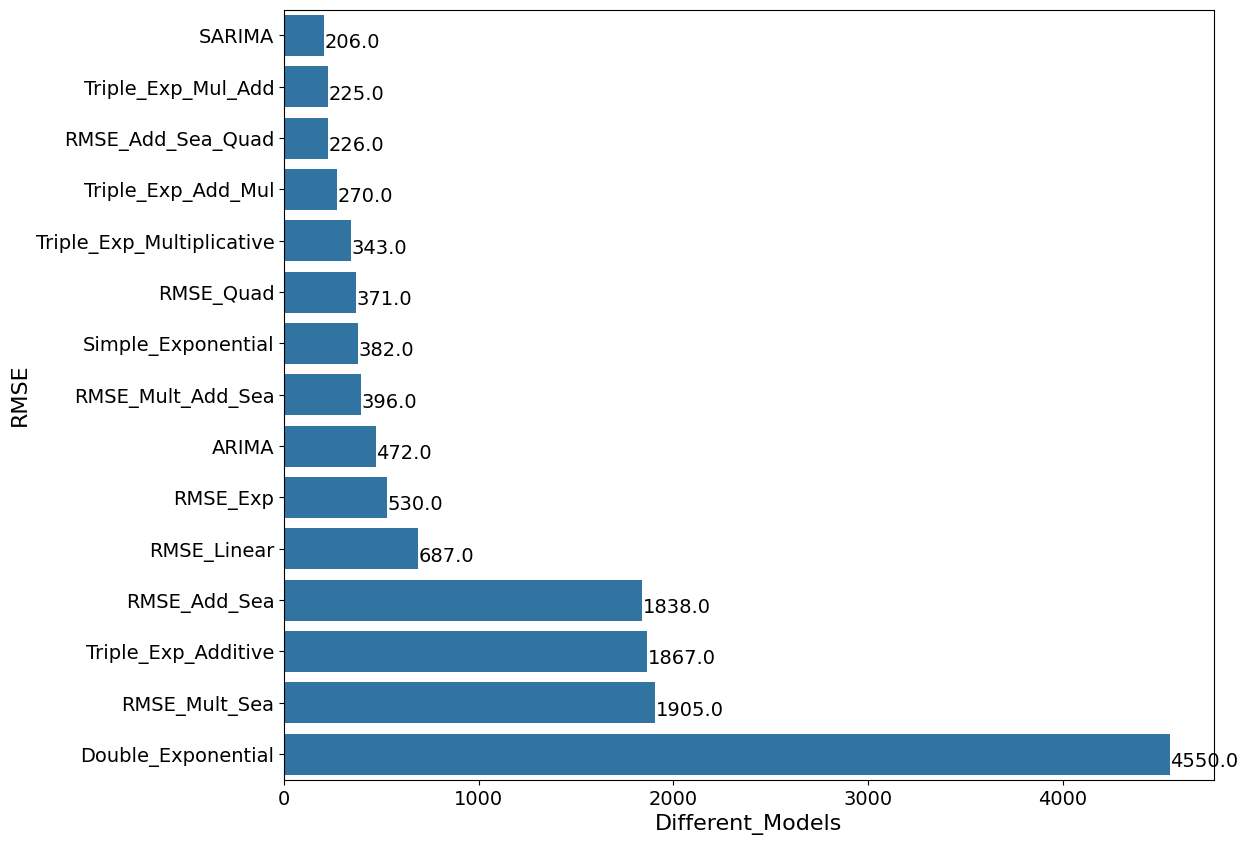

In [110]:
f, axe = plt.subplots(1,1, figsize=(12,10))
sns.barplot(x='RMSE_Values', y='Models', data=e, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

for i, v in enumerate(np.round(e.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v), fontsize= 14)

plt.show()


### Triple Exponential Method with Multiplicative Seasonality and Additive Trend. The best model we have got so far with the lowest RMSE and lowest MAPE.